##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 图像分割

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/segmentation">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png">     在 TensorFlow.org 上查看</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/segmentation.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/segmentation.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/segmentation.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

这篇教程将重点讨论图像分割任务，使用的是改进版的 [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)。

## 什么是图像分割？

在图像分类任务中，网络会为每个输入图像分配一个标签（或类）。但是，如何了解该对象的形状、哪个像素属于哪个对象等信息呢？在这种情况下，您需要为图像的每个像素分配一个类。此任务称为分割。分割模型会返回有关图像的更详细信息。图像分割在医学成像、自动驾驶汽车和卫星成像等方面有很多应用。

本教程使用 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf))。该数据集由 37 个宠物品种的图像组成，每个品种有 200 个图像（训练拆分和测试拆分各有 100 个）。每个图像都包含相应的标签和像素级掩码。掩码是每个像素的类标签。每个像素都会被划入以下三个类别之一：

- 第 1 类：属于宠物的像素。
- 第 2 类：宠物边缘的像素。
- 第 3 类：以上都不是/周围的像素。

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmpfs/tmp/pip-req-build-wsz96mq4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmpfs/tmp/pip-req-build-wsz96mq4


  Resolved https://github.com/tensorflow/examples.git to commit d639fe4b394c391dfdf6d00171cfa916a7fc1175


  Preparing metadata (setup.py) ... -

 done


 \

 |

 done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1698779193.1223017319550583858672544386243344910876866777461-py3-none-any.whl size=301585 sha256=62464084e27f57cfef9ba743ff9b0a32b9c8548c0f5e17fff99a0e65d2420a27
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-sd92pv0x/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

2023-11-07 22:50:13.585808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 22:50:13.585864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 22:50:13.587520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## 下载 Oxford-IIIT Pets 数据集

该数据集可从 [TensorFlow Datasets](https://tensorflow.google.cn/datasets/catalog/oxford_iiit_pet) 获得。分割掩码包含在版本 3 以上的版本中。

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

此外，图像颜色值被归一化到 `[0,1]` 范围。最后，如上所述，分割掩码中的像素被标记为 {1, 2, 3}。为方便起见，从分割掩码中减去 1，得到的标签为：{0, 1, 2}。

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

数据集已包含所需的训练拆分和测试拆分，因此请继续使用相同的拆分。

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

下面的类通过随机翻转图像来执行简单的增强。请转到[图像增强](data_augmentation.ipynb)教程以了解更多信息。


In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

构建输入流水线，在对输入进行批处理后应用增强：

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

呈现数据集中的图像样本及其对应的掩码：

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


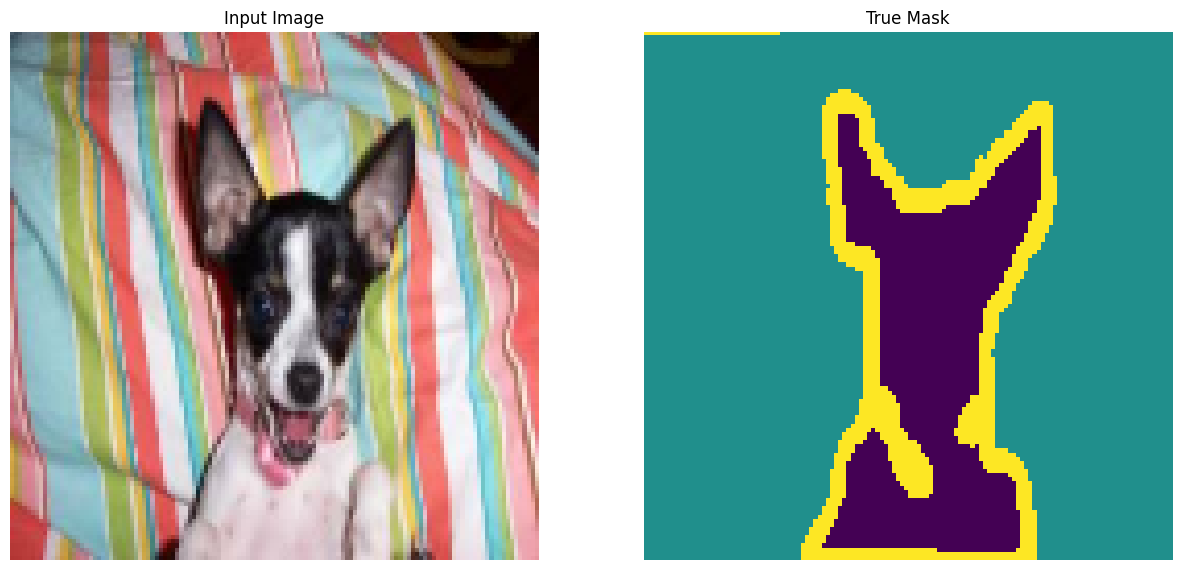

2023-11-07 22:50:22.420833: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


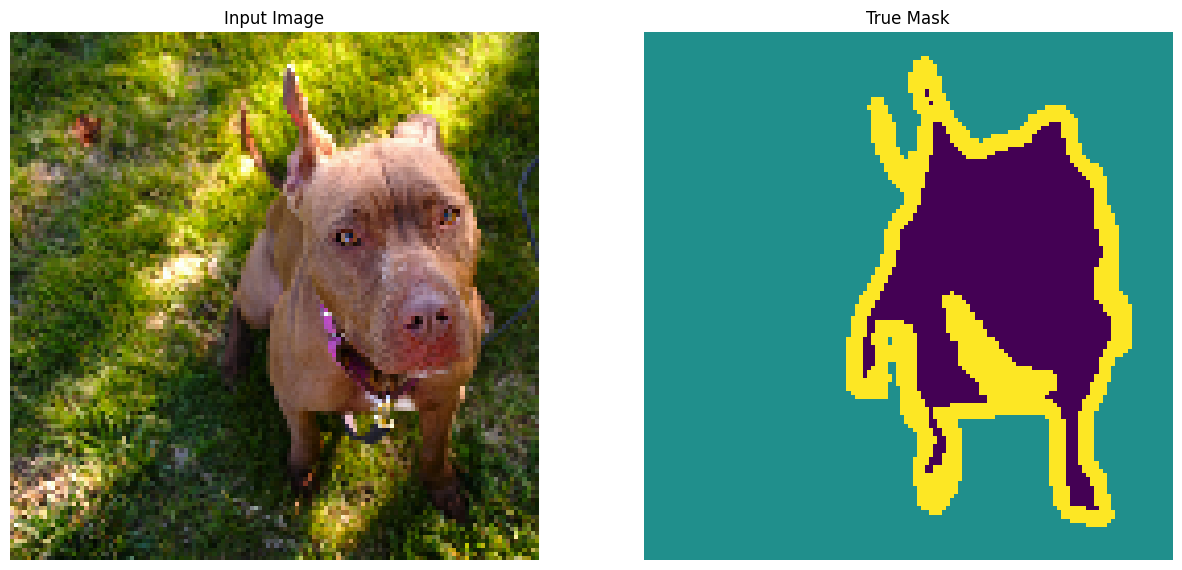

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## 定义模型

这里使用的模型是修改后的 [U-Net](https://arxiv.org/abs/1505.04597)。U-Net 由编码器（下采样器）和解码器（上采样器）组成。为了学习稳健的特征并减少可训练参数的数量，请使用预训练模型 [MobileNetV2](https://arxiv.org/abs/1801.04381) 作为编码器。对于解码器，您将使用上采样块，该块已在 TensorFlow Examples 仓库的 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 示例中实现。（请查看笔记本中的 [pix2pix：使用条件 GAN 进行图像到图像转换](../generative/pix2pix.ipynb)教程。）


如前所述，编码器是一个预训练的 MobileNetV2 模型。您将使用来自 `tf.keras.applications` 的模型。编码器由模型中中间层的特定输出组成。请注意，在训练过程中不会训练编码器。

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

   8192/9406464 [..............................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


解码器/上采样器只是在 TensorFlow 示例中实现的一系列上采样块：

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

请注意，最后一层的筛选器数量设置为 `output_channels` 的数量。每个类将有一个输出通道。

## 训练模型

现在，剩下要做的是编译和训练模型。

由于这是一个多类分类问题，请使用 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数，并将 `from_logits` 参数设置为 `True`，因为标签是标量整数，而不是每个类的每个像素的分数向量。

运行推断时，分配给像素的标签是具有最高值的通道。这就是 `create_mask` 函数的作用。

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

绘制最终的模型架构：

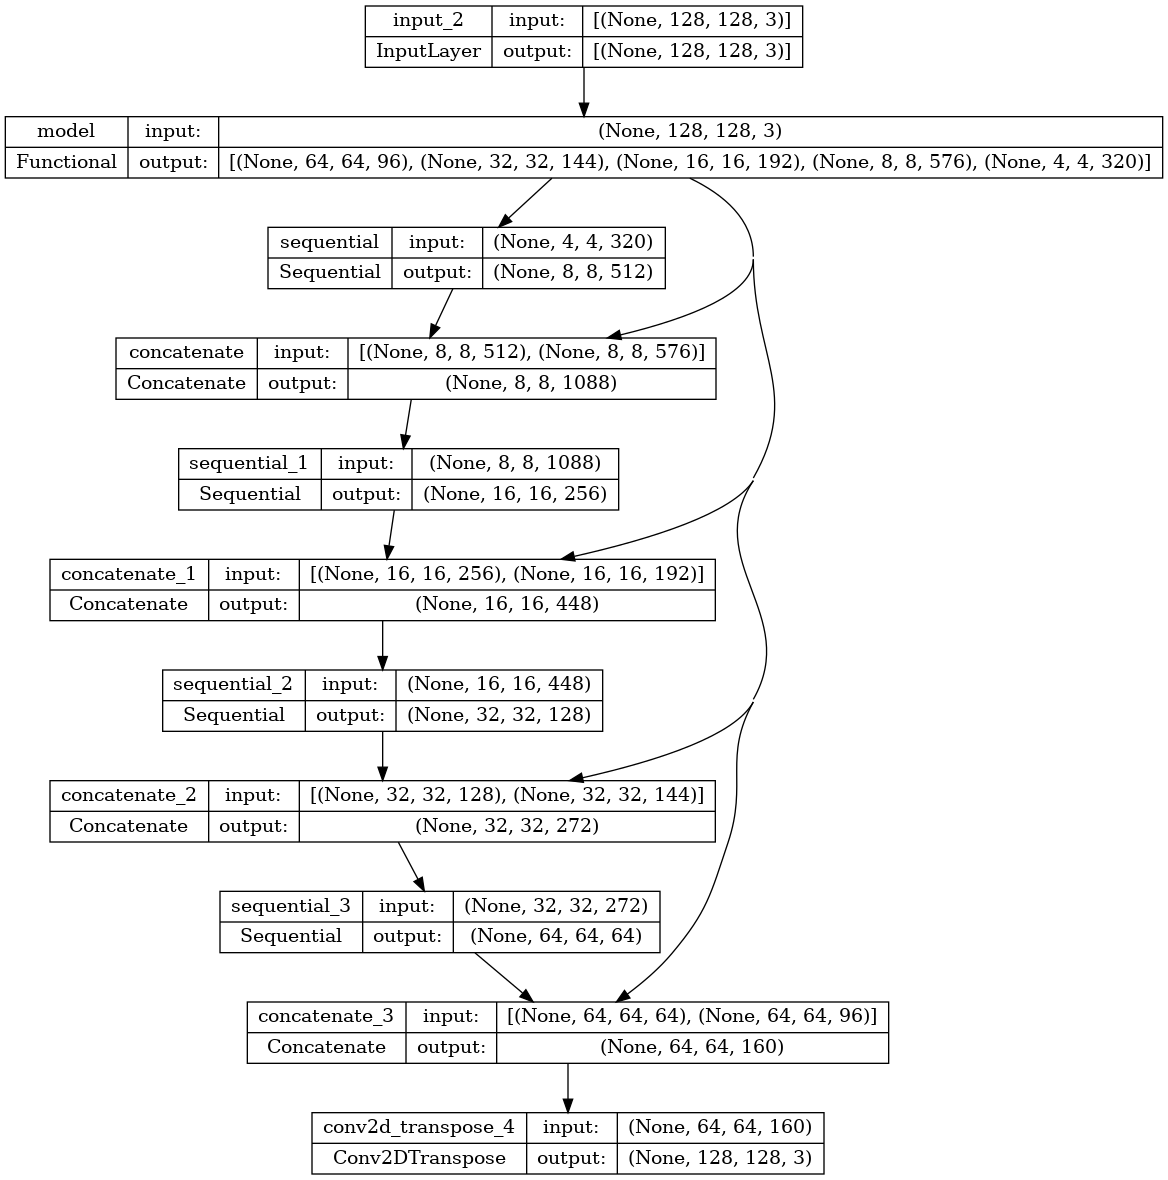

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

在训练前试用一下该模型，以检查其预测结果：

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


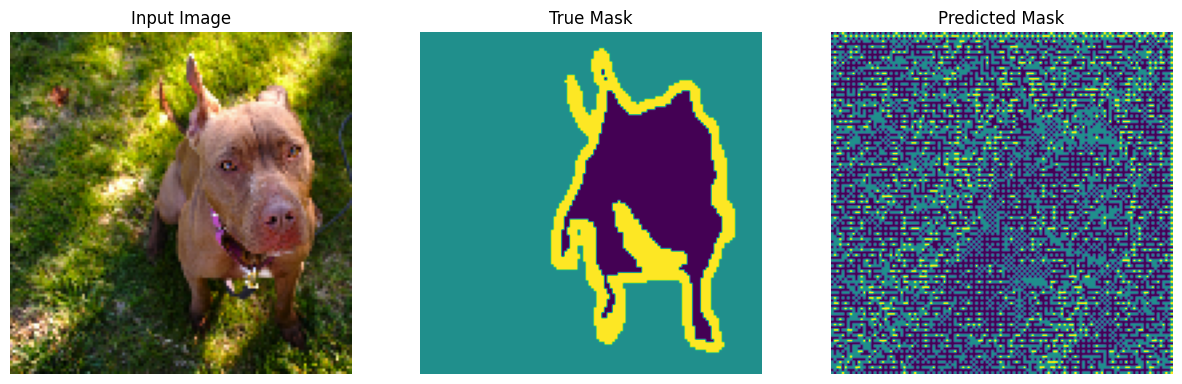

In [21]:
show_predictions()

下面定义的回调用于观察模型在训练过程中的改进情况：

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


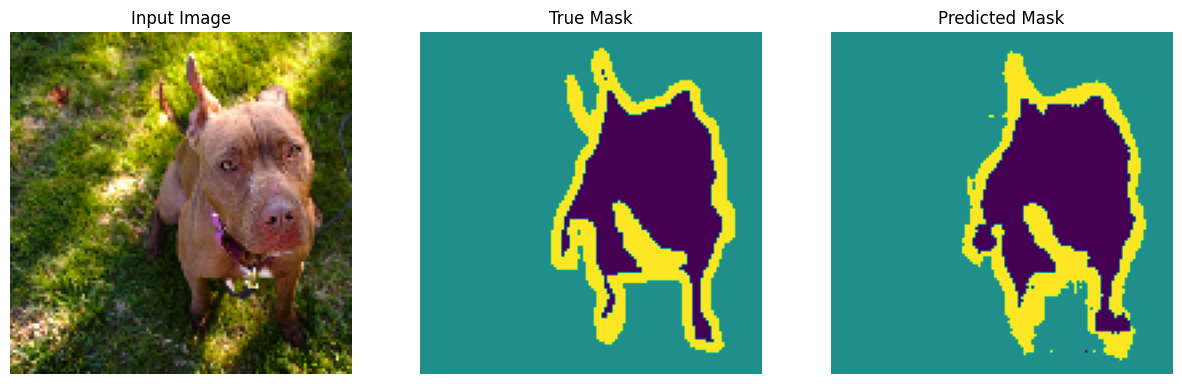


Sample Prediction after epoch 20

57/57 [==============================] - 8s 144ms/step - loss: 0.1713 - accuracy: 0.9301 - val_loss: 0.2807 - val_accuracy: 0.9046


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

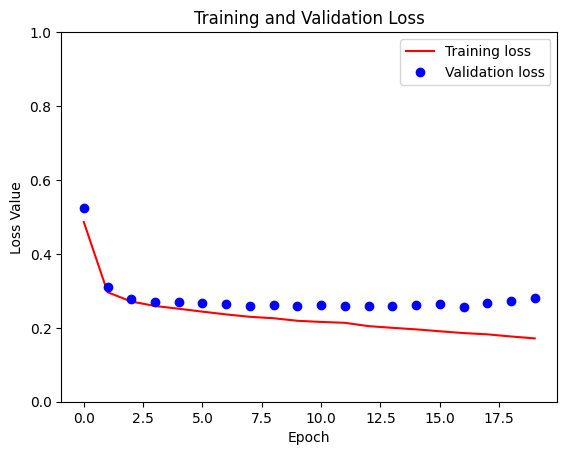

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 做出预测

接下来，进行一些预测。为了节省时间，保持较小周期数，但您也可以将其设置得更高以获得更准确的结果。

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 25ms/step


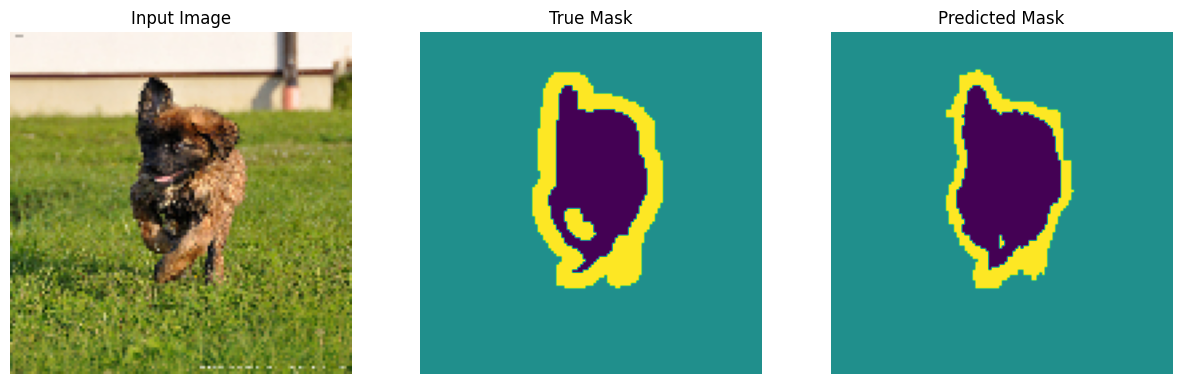

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 32ms/step


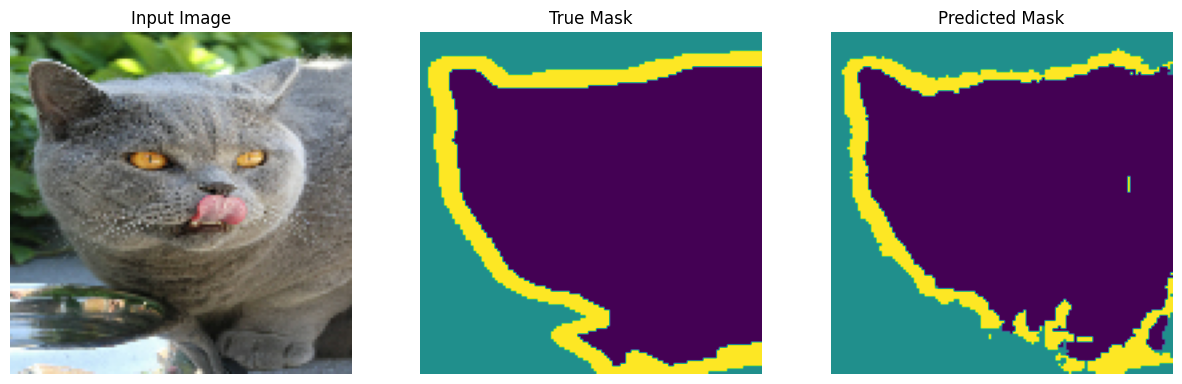

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 35ms/step


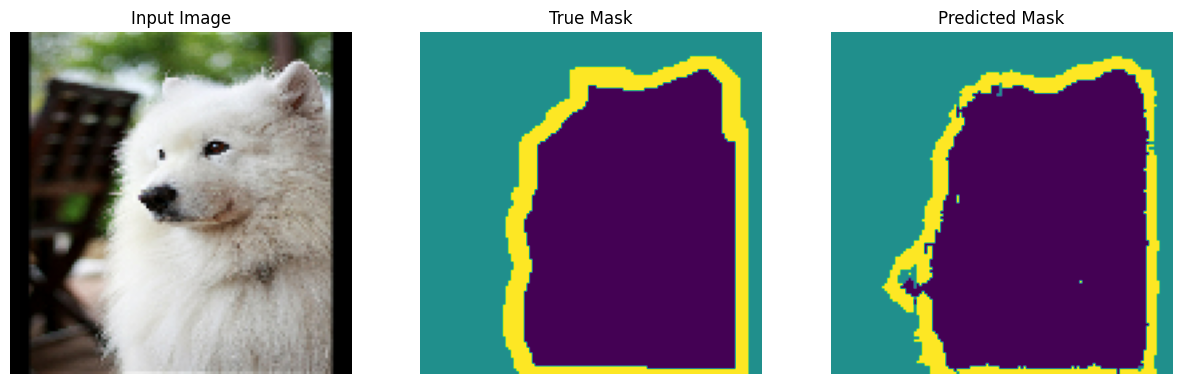

In [25]:
show_predictions(test_batches, 3)

## 可选：不平衡的类和类权重

语义分割数据集可能会高度不平衡，这意味着特定类别的像素可以比其他类别的像素更多地出现在图像内部。由于分割问题可以被视为逐像素分类问题，因此您可以通过加权损失函数来解决不平衡问题。这是处理此问题的一种简单而优雅的方式。请参阅[不平衡数据分类](../structured_data/imbalanced_data.ipynb)教程了解更多信息。

为[避免歧义](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748)，{code 1}Model.fit{/code 1} 不支持具有 3 个以上维度的目标的 `class_weight` 参数。

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20


 1/57 [..............................] - ETA: 1:48 - loss: 0.2473 - accuracy: 0.9342

 2/57 [>.............................] - ETA: 6s - loss: 0.2492 - accuracy: 0.9305  

 3/57 [>.............................] - ETA: 6s - loss: 0.2394 - accuracy: 0.9294

 4/57 [=>............................] - ETA: 5s - loss: 0.2423 - accuracy: 0.9261

 5/57 [=>............................] - ETA: 5s - loss: 0.2440 - accuracy: 0.9241

 6/57 [==>...........................] - ETA: 5s - loss: 0.2422 - accuracy: 0.9248

 7/57 [==>...........................] - ETA: 5s - loss: 0.2420 - accuracy: 0.9257

 8/57 [===>..........................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9261

 9/57 [===>..........................] - ETA: 5s - loss: 0.2425 - accuracy: 0.9260

10/57 [====>.........................] - ETA: 5s - loss: 0.2442 - accuracy: 0.9256

11/57 [====>.........................] - ETA: 5s - loss: 0.2447 - accuracy: 0.9252

12/57 [=====>........................] - ETA: 5s - loss: 0.2456 - accuracy: 0.9248

13/57 [=====>........................] - ETA: 4s - loss: 0.2460 - accuracy: 0.9245

14/57 [======>.......................] - ETA: 4s - loss: 0.2467 - accuracy: 0.9245

15/57 [======>.......................] - ETA: 4s - loss: 0.2473 - accuracy: 0.9244

16/57 [=======>......................] - ETA: 4s - loss: 0.2476 - accuracy: 0.9247

17/57 [=======>......................] - ETA: 4s - loss: 0.2480 - accuracy: 0.9247

18/57 [========>.....................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9246

19/57 [=========>....................] - ETA: 4s - loss: 0.2503 - accuracy: 0.9239

20/57 [=========>....................] - ETA: 4s - loss: 0.2518 - accuracy: 0.9232

21/57 [==========>...................] - ETA: 4s - loss: 0.2522 - accuracy: 0.9230

22/57 [==========>...................] - ETA: 3s - loss: 0.2532 - accuracy: 0.9229

23/57 [===========>..................] - ETA: 3s - loss: 0.2529 - accuracy: 0.9233

24/57 [===========>..................] - ETA: 3s - loss: 0.2536 - accuracy: 0.9231

25/57 [============>.................] - ETA: 3s - loss: 0.2541 - accuracy: 0.9228

26/57 [============>.................] - ETA: 3s - loss: 0.2550 - accuracy: 0.9224

27/57 [=============>................] - ETA: 3s - loss: 0.2547 - accuracy: 0.9225

28/57 [=============>................] - ETA: 3s - loss: 0.2548 - accuracy: 0.9224

29/57 [==============>...............] - ETA: 3s - loss: 0.2548 - accuracy: 0.9225

30/57 [==============>...............] - ETA: 3s - loss: 0.2548 - accuracy: 0.9225

31/57 [===============>..............] - ETA: 2s - loss: 0.2551 - accuracy: 0.9225

32/57 [===============>..............] - ETA: 2s - loss: 0.2550 - accuracy: 0.9224

33/57 [================>.............] - ETA: 2s - loss: 0.2547 - accuracy: 0.9225

34/57 [================>.............] - ETA: 2s - loss: 0.2548 - accuracy: 0.9225

35/57 [=================>............] - ETA: 2s - loss: 0.2546 - accuracy: 0.9227

36/57 [=================>............] - ETA: 2s - loss: 0.2541 - accuracy: 0.9228

37/57 [==================>...........] - ETA: 2s - loss: 0.2540 - accuracy: 0.9228

38/57 [===================>..........] - ETA: 2s - loss: 0.2540 - accuracy: 0.9228

39/57 [===================>..........] - ETA: 2s - loss: 0.2545 - accuracy: 0.9227

40/57 [====================>.........] - ETA: 1s - loss: 0.2542 - accuracy: 0.9228

41/57 [====================>.........] - ETA: 1s - loss: 0.2543 - accuracy: 0.9228

42/57 [=====================>........] - ETA: 1s - loss: 0.2536 - accuracy: 0.9230

43/57 [=====================>........] - ETA: 1s - loss: 0.2535 - accuracy: 0.9230

44/57 [======================>.......] - ETA: 1s - loss: 0.2545 - accuracy: 0.9228

45/57 [======================>.......] - ETA: 1s - loss: 0.2550 - accuracy: 0.9227

46/57 [=======================>......] - ETA: 1s - loss: 0.2551 - accuracy: 0.9227

47/57 [=======================>......] - ETA: 1s - loss: 0.2555 - accuracy: 0.9225

48/57 [========================>.....] - ETA: 1s - loss: 0.2557 - accuracy: 0.9224

49/57 [========================>.....] - ETA: 0s - loss: 0.2561 - accuracy: 0.9224

50/57 [=========================>....] - ETA: 0s - loss: 0.2563 - accuracy: 0.9223

51/57 [=========================>....] - ETA: 0s - loss: 0.2558 - accuracy: 0.9225

52/57 [==========================>...] - ETA: 0s - loss: 0.2564 - accuracy: 0.9223

53/57 [==========================>...] - ETA: 0s - loss: 0.2567 - accuracy: 0.9223

54/57 [===========================>..] - ETA: 0s - loss: 0.2569 - accuracy: 0.9223

55/57 [===========================>..] - ETA: 0s - loss: 0.2574 - accuracy: 0.9220

56/57 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.9219

57/57 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9219

57/57 [==============================] - 8s 114ms/step - loss: 0.2579 - accuracy: 0.9219


Epoch 2/20


 1/57 [..............................] - ETA: 3s - loss: 0.2644 - accuracy: 0.9209

 2/57 [>.............................] - ETA: 6s - loss: 0.2620 - accuracy: 0.9242

 3/57 [>.............................] - ETA: 6s - loss: 0.2753 - accuracy: 0.9220

 4/57 [=>............................] - ETA: 6s - loss: 0.2711 - accuracy: 0.9214

 5/57 [=>............................] - ETA: 5s - loss: 0.2684 - accuracy: 0.9219

 6/57 [==>...........................] - ETA: 5s - loss: 0.2666 - accuracy: 0.9216

 7/57 [==>...........................] - ETA: 5s - loss: 0.2692 - accuracy: 0.9209

 8/57 [===>..........................] - ETA: 5s - loss: 0.2691 - accuracy: 0.9209

 9/57 [===>..........................] - ETA: 5s - loss: 0.2670 - accuracy: 0.9214

10/57 [====>.........................] - ETA: 5s - loss: 0.2686 - accuracy: 0.9213

11/57 [====>.........................] - ETA: 5s - loss: 0.2701 - accuracy: 0.9208

12/57 [=====>........................] - ETA: 5s - loss: 0.2698 - accuracy: 0.9208

13/57 [=====>........................] - ETA: 4s - loss: 0.2699 - accuracy: 0.9205

14/57 [======>.......................] - ETA: 4s - loss: 0.2690 - accuracy: 0.9208

15/57 [======>.......................] - ETA: 4s - loss: 0.2683 - accuracy: 0.9208

16/57 [=======>......................] - ETA: 4s - loss: 0.2687 - accuracy: 0.9207

17/57 [=======>......................] - ETA: 4s - loss: 0.2684 - accuracy: 0.9210

18/57 [========>.....................] - ETA: 4s - loss: 0.2668 - accuracy: 0.9212

19/57 [=========>....................] - ETA: 4s - loss: 0.2680 - accuracy: 0.9206

20/57 [=========>....................] - ETA: 4s - loss: 0.2693 - accuracy: 0.9202

21/57 [==========>...................] - ETA: 4s - loss: 0.2693 - accuracy: 0.9203

22/57 [==========>...................] - ETA: 3s - loss: 0.2702 - accuracy: 0.9199

23/57 [===========>..................] - ETA: 3s - loss: 0.2712 - accuracy: 0.9196

24/57 [===========>..................] - ETA: 3s - loss: 0.2716 - accuracy: 0.9197

25/57 [============>.................] - ETA: 3s - loss: 0.2718 - accuracy: 0.9196

26/57 [============>.................] - ETA: 3s - loss: 0.2712 - accuracy: 0.9197

27/57 [=============>................] - ETA: 3s - loss: 0.2710 - accuracy: 0.9197

28/57 [=============>................] - ETA: 3s - loss: 0.2698 - accuracy: 0.9200

29/57 [==============>...............] - ETA: 3s - loss: 0.2695 - accuracy: 0.9200

30/57 [==============>...............] - ETA: 3s - loss: 0.2700 - accuracy: 0.9198

31/57 [===============>..............] - ETA: 2s - loss: 0.2690 - accuracy: 0.9201

32/57 [===============>..............] - ETA: 2s - loss: 0.2685 - accuracy: 0.9202

33/57 [================>.............] - ETA: 2s - loss: 0.2682 - accuracy: 0.9203

34/57 [================>.............] - ETA: 2s - loss: 0.2676 - accuracy: 0.9204

35/57 [=================>............] - ETA: 2s - loss: 0.2673 - accuracy: 0.9205

36/57 [=================>............] - ETA: 2s - loss: 0.2678 - accuracy: 0.9203

37/57 [==================>...........] - ETA: 2s - loss: 0.2677 - accuracy: 0.9203

38/57 [===================>..........] - ETA: 2s - loss: 0.2683 - accuracy: 0.9200

39/57 [===================>..........] - ETA: 2s - loss: 0.2677 - accuracy: 0.9201

40/57 [====================>.........] - ETA: 1s - loss: 0.2683 - accuracy: 0.9201

41/57 [====================>.........] - ETA: 1s - loss: 0.2684 - accuracy: 0.9201

42/57 [=====================>........] - ETA: 1s - loss: 0.2683 - accuracy: 0.9202

43/57 [=====================>........] - ETA: 1s - loss: 0.2680 - accuracy: 0.9201

44/57 [======================>.......] - ETA: 1s - loss: 0.2683 - accuracy: 0.9199

45/57 [======================>.......] - ETA: 1s - loss: 0.2689 - accuracy: 0.9197

46/57 [=======================>......] - ETA: 1s - loss: 0.2683 - accuracy: 0.9198

47/57 [=======================>......] - ETA: 1s - loss: 0.2684 - accuracy: 0.9199

48/57 [========================>.....] - ETA: 1s - loss: 0.2682 - accuracy: 0.9200

49/57 [========================>.....] - ETA: 0s - loss: 0.2682 - accuracy: 0.9200

50/57 [=========================>....] - ETA: 0s - loss: 0.2681 - accuracy: 0.9200

51/57 [=========================>....] - ETA: 0s - loss: 0.2682 - accuracy: 0.9199

52/57 [==========================>...] - ETA: 0s - loss: 0.2683 - accuracy: 0.9199

53/57 [==========================>...] - ETA: 0s - loss: 0.2680 - accuracy: 0.9199

54/57 [===========================>..] - ETA: 0s - loss: 0.2681 - accuracy: 0.9199

55/57 [===========================>..] - ETA: 0s - loss: 0.2678 - accuracy: 0.9200

56/57 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.9201

57/57 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9201

57/57 [==============================] - 6s 114ms/step - loss: 0.2671 - accuracy: 0.9201


Epoch 3/20


 1/57 [..............................] - ETA: 6s - loss: 0.2645 - accuracy: 0.9202

 2/57 [>.............................] - ETA: 3s - loss: 0.2561 - accuracy: 0.9221

 3/57 [>.............................] - ETA: 4s - loss: 0.2508 - accuracy: 0.9237

 4/57 [=>............................] - ETA: 5s - loss: 0.2528 - accuracy: 0.9230

 5/57 [=>............................] - ETA: 5s - loss: 0.2481 - accuracy: 0.9240

 6/57 [==>...........................] - ETA: 5s - loss: 0.2478 - accuracy: 0.9244

 7/57 [==>...........................] - ETA: 5s - loss: 0.2463 - accuracy: 0.9249

 8/57 [===>..........................] - ETA: 5s - loss: 0.2432 - accuracy: 0.9257

 9/57 [===>..........................] - ETA: 5s - loss: 0.2473 - accuracy: 0.9244

10/57 [====>.........................] - ETA: 5s - loss: 0.2477 - accuracy: 0.9244

11/57 [====>.........................] - ETA: 5s - loss: 0.2505 - accuracy: 0.9234

12/57 [=====>........................] - ETA: 4s - loss: 0.2501 - accuracy: 0.9237

13/57 [=====>........................] - ETA: 4s - loss: 0.2483 - accuracy: 0.9243

14/57 [======>.......................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9243

15/57 [======>.......................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9246

16/57 [=======>......................] - ETA: 4s - loss: 0.2479 - accuracy: 0.9245

17/57 [=======>......................] - ETA: 4s - loss: 0.2477 - accuracy: 0.9245

18/57 [========>.....................] - ETA: 4s - loss: 0.2484 - accuracy: 0.9244

19/57 [=========>....................] - ETA: 4s - loss: 0.2486 - accuracy: 0.9243

20/57 [=========>....................] - ETA: 4s - loss: 0.2492 - accuracy: 0.9241

21/57 [==========>...................] - ETA: 4s - loss: 0.2493 - accuracy: 0.9240

22/57 [==========>...................] - ETA: 3s - loss: 0.2489 - accuracy: 0.9243

23/57 [===========>..................] - ETA: 3s - loss: 0.2494 - accuracy: 0.9242

24/57 [===========>..................] - ETA: 3s - loss: 0.2490 - accuracy: 0.9244

25/57 [============>.................] - ETA: 3s - loss: 0.2480 - accuracy: 0.9245

26/57 [============>.................] - ETA: 3s - loss: 0.2477 - accuracy: 0.9243

27/57 [=============>................] - ETA: 3s - loss: 0.2473 - accuracy: 0.9244

28/57 [=============>................] - ETA: 3s - loss: 0.2470 - accuracy: 0.9246

29/57 [==============>...............] - ETA: 3s - loss: 0.2463 - accuracy: 0.9250

30/57 [==============>...............] - ETA: 3s - loss: 0.2458 - accuracy: 0.9252

31/57 [===============>..............] - ETA: 2s - loss: 0.2465 - accuracy: 0.9248

32/57 [===============>..............] - ETA: 2s - loss: 0.2462 - accuracy: 0.9247

33/57 [================>.............] - ETA: 2s - loss: 0.2473 - accuracy: 0.9244

34/57 [================>.............] - ETA: 2s - loss: 0.2475 - accuracy: 0.9244

35/57 [=================>............] - ETA: 2s - loss: 0.2474 - accuracy: 0.9245

36/57 [=================>............] - ETA: 2s - loss: 0.2473 - accuracy: 0.9246

37/57 [==================>...........] - ETA: 2s - loss: 0.2472 - accuracy: 0.9246

38/57 [===================>..........] - ETA: 2s - loss: 0.2465 - accuracy: 0.9248

39/57 [===================>..........] - ETA: 2s - loss: 0.2463 - accuracy: 0.9249

40/57 [====================>.........] - ETA: 1s - loss: 0.2463 - accuracy: 0.9248

41/57 [====================>.........] - ETA: 1s - loss: 0.2473 - accuracy: 0.9245

42/57 [=====================>........] - ETA: 1s - loss: 0.2473 - accuracy: 0.9246

43/57 [=====================>........] - ETA: 1s - loss: 0.2471 - accuracy: 0.9246

44/57 [======================>.......] - ETA: 1s - loss: 0.2475 - accuracy: 0.9245

45/57 [======================>.......] - ETA: 1s - loss: 0.2475 - accuracy: 0.9245

46/57 [=======================>......] - ETA: 1s - loss: 0.2481 - accuracy: 0.9244

47/57 [=======================>......] - ETA: 1s - loss: 0.2483 - accuracy: 0.9244

48/57 [========================>.....] - ETA: 1s - loss: 0.2481 - accuracy: 0.9244

49/57 [========================>.....] - ETA: 0s - loss: 0.2484 - accuracy: 0.9243

50/57 [=========================>....] - ETA: 0s - loss: 0.2480 - accuracy: 0.9244

51/57 [=========================>....] - ETA: 0s - loss: 0.2477 - accuracy: 0.9245

52/57 [==========================>...] - ETA: 0s - loss: 0.2480 - accuracy: 0.9245

53/57 [==========================>...] - ETA: 0s - loss: 0.2479 - accuracy: 0.9245

54/57 [===========================>..] - ETA: 0s - loss: 0.2480 - accuracy: 0.9245

55/57 [===========================>..] - ETA: 0s - loss: 0.2479 - accuracy: 0.9245

56/57 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9246

57/57 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9245

57/57 [==============================] - 6s 114ms/step - loss: 0.2479 - accuracy: 0.9245


Epoch 4/20


 1/57 [..............................] - ETA: 6s - loss: 0.2177 - accuracy: 0.9286

 2/57 [>.............................] - ETA: 6s - loss: 0.2306 - accuracy: 0.9272

 3/57 [>.............................] - ETA: 4s - loss: 0.2333 - accuracy: 0.9269

 4/57 [=>............................] - ETA: 5s - loss: 0.2313 - accuracy: 0.9284

 5/57 [=>............................] - ETA: 5s - loss: 0.2330 - accuracy: 0.9290

 6/57 [==>...........................] - ETA: 5s - loss: 0.2338 - accuracy: 0.9284

 7/57 [==>...........................] - ETA: 5s - loss: 0.2408 - accuracy: 0.9263

 8/57 [===>..........................] - ETA: 5s - loss: 0.2374 - accuracy: 0.9266

 9/57 [===>..........................] - ETA: 5s - loss: 0.2379 - accuracy: 0.9262

10/57 [====>.........................] - ETA: 5s - loss: 0.2357 - accuracy: 0.9271

11/57 [====>.........................] - ETA: 5s - loss: 0.2370 - accuracy: 0.9267

12/57 [=====>........................] - ETA: 4s - loss: 0.2382 - accuracy: 0.9265

13/57 [=====>........................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9266

14/57 [======>.......................] - ETA: 4s - loss: 0.2381 - accuracy: 0.9269

15/57 [======>.......................] - ETA: 4s - loss: 0.2370 - accuracy: 0.9272

16/57 [=======>......................] - ETA: 4s - loss: 0.2371 - accuracy: 0.9267

17/57 [=======>......................] - ETA: 4s - loss: 0.2377 - accuracy: 0.9265

18/57 [========>.....................] - ETA: 4s - loss: 0.2385 - accuracy: 0.9262

19/57 [=========>....................] - ETA: 4s - loss: 0.2391 - accuracy: 0.9261

20/57 [=========>....................] - ETA: 4s - loss: 0.2384 - accuracy: 0.9265

21/57 [==========>...................] - ETA: 4s - loss: 0.2384 - accuracy: 0.9265

22/57 [==========>...................] - ETA: 3s - loss: 0.2385 - accuracy: 0.9266

23/57 [===========>..................] - ETA: 3s - loss: 0.2378 - accuracy: 0.9267

24/57 [===========>..................] - ETA: 3s - loss: 0.2374 - accuracy: 0.9268

25/57 [============>.................] - ETA: 3s - loss: 0.2375 - accuracy: 0.9267

26/57 [============>.................] - ETA: 3s - loss: 0.2373 - accuracy: 0.9267

27/57 [=============>................] - ETA: 3s - loss: 0.2379 - accuracy: 0.9265

28/57 [=============>................] - ETA: 3s - loss: 0.2373 - accuracy: 0.9267

29/57 [==============>...............] - ETA: 3s - loss: 0.2371 - accuracy: 0.9269

30/57 [==============>...............] - ETA: 3s - loss: 0.2374 - accuracy: 0.9269

31/57 [===============>..............] - ETA: 2s - loss: 0.2378 - accuracy: 0.9267

32/57 [===============>..............] - ETA: 2s - loss: 0.2374 - accuracy: 0.9267

33/57 [================>.............] - ETA: 2s - loss: 0.2374 - accuracy: 0.9267

34/57 [================>.............] - ETA: 2s - loss: 0.2369 - accuracy: 0.9268

35/57 [=================>............] - ETA: 2s - loss: 0.2360 - accuracy: 0.9271

36/57 [=================>............] - ETA: 2s - loss: 0.2354 - accuracy: 0.9273

37/57 [==================>...........] - ETA: 2s - loss: 0.2357 - accuracy: 0.9272

38/57 [===================>..........] - ETA: 2s - loss: 0.2350 - accuracy: 0.9275

39/57 [===================>..........] - ETA: 2s - loss: 0.2350 - accuracy: 0.9274

40/57 [====================>.........] - ETA: 1s - loss: 0.2346 - accuracy: 0.9275

41/57 [====================>.........] - ETA: 1s - loss: 0.2341 - accuracy: 0.9276

42/57 [=====================>........] - ETA: 1s - loss: 0.2344 - accuracy: 0.9275

43/57 [=====================>........] - ETA: 1s - loss: 0.2341 - accuracy: 0.9276

44/57 [======================>.......] - ETA: 1s - loss: 0.2342 - accuracy: 0.9276

45/57 [======================>.......] - ETA: 1s - loss: 0.2340 - accuracy: 0.9277

46/57 [=======================>......] - ETA: 1s - loss: 0.2337 - accuracy: 0.9278

47/57 [=======================>......] - ETA: 1s - loss: 0.2334 - accuracy: 0.9278

48/57 [========================>.....] - ETA: 1s - loss: 0.2337 - accuracy: 0.9278

49/57 [========================>.....] - ETA: 0s - loss: 0.2337 - accuracy: 0.9278

50/57 [=========================>....] - ETA: 0s - loss: 0.2339 - accuracy: 0.9277

51/57 [=========================>....] - ETA: 0s - loss: 0.2339 - accuracy: 0.9277

52/57 [==========================>...] - ETA: 0s - loss: 0.2334 - accuracy: 0.9278

53/57 [==========================>...] - ETA: 0s - loss: 0.2334 - accuracy: 0.9278

54/57 [===========================>..] - ETA: 0s - loss: 0.2333 - accuracy: 0.9279

55/57 [===========================>..] - ETA: 0s - loss: 0.2334 - accuracy: 0.9278

56/57 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.9279

57/57 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9279

57/57 [==============================] - 6s 114ms/step - loss: 0.2331 - accuracy: 0.9279


Epoch 5/20


 1/57 [..............................] - ETA: 6s - loss: 0.2317 - accuracy: 0.9269

 2/57 [>.............................] - ETA: 6s - loss: 0.2400 - accuracy: 0.9259

 3/57 [>.............................] - ETA: 6s - loss: 0.2332 - accuracy: 0.9282

 4/57 [=>............................] - ETA: 5s - loss: 0.2321 - accuracy: 0.9287

 5/57 [=>............................] - ETA: 5s - loss: 0.2319 - accuracy: 0.9282

 6/57 [==>...........................] - ETA: 5s - loss: 0.2331 - accuracy: 0.9273

 7/57 [==>...........................] - ETA: 5s - loss: 0.2331 - accuracy: 0.9273

 8/57 [===>..........................] - ETA: 5s - loss: 0.2330 - accuracy: 0.9273

 9/57 [===>..........................] - ETA: 5s - loss: 0.2355 - accuracy: 0.9270

10/57 [====>.........................] - ETA: 5s - loss: 0.2337 - accuracy: 0.9276

11/57 [====>.........................] - ETA: 5s - loss: 0.2318 - accuracy: 0.9284

12/57 [=====>........................] - ETA: 4s - loss: 0.2316 - accuracy: 0.9285

13/57 [=====>........................] - ETA: 4s - loss: 0.2328 - accuracy: 0.9279

14/57 [======>.......................] - ETA: 4s - loss: 0.2326 - accuracy: 0.9277

15/57 [======>.......................] - ETA: 4s - loss: 0.2372 - accuracy: 0.9268

16/57 [=======>......................] - ETA: 4s - loss: 0.2366 - accuracy: 0.9270

17/57 [=======>......................] - ETA: 4s - loss: 0.2351 - accuracy: 0.9275

18/57 [========>.....................] - ETA: 4s - loss: 0.2353 - accuracy: 0.9275

19/57 [=========>....................] - ETA: 4s - loss: 0.2355 - accuracy: 0.9277

20/57 [=========>....................] - ETA: 4s - loss: 0.2351 - accuracy: 0.9277

21/57 [==========>...................] - ETA: 4s - loss: 0.2350 - accuracy: 0.9276

22/57 [==========>...................] - ETA: 3s - loss: 0.2356 - accuracy: 0.9273

23/57 [===========>..................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9270

24/57 [===========>..................] - ETA: 3s - loss: 0.2364 - accuracy: 0.9271

25/57 [============>.................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9272

26/57 [============>.................] - ETA: 3s - loss: 0.2356 - accuracy: 0.9277

27/57 [=============>................] - ETA: 3s - loss: 0.2355 - accuracy: 0.9277

28/57 [=============>................] - ETA: 3s - loss: 0.2347 - accuracy: 0.9280

29/57 [==============>...............] - ETA: 3s - loss: 0.2342 - accuracy: 0.9282

30/57 [==============>...............] - ETA: 3s - loss: 0.2333 - accuracy: 0.9283

31/57 [===============>..............] - ETA: 2s - loss: 0.2336 - accuracy: 0.9281

32/57 [===============>..............] - ETA: 2s - loss: 0.2330 - accuracy: 0.9281

33/57 [================>.............] - ETA: 2s - loss: 0.2327 - accuracy: 0.9282

34/57 [================>.............] - ETA: 2s - loss: 0.2322 - accuracy: 0.9284

35/57 [=================>............] - ETA: 2s - loss: 0.2322 - accuracy: 0.9284

36/57 [=================>............] - ETA: 2s - loss: 0.2320 - accuracy: 0.9286

37/57 [==================>...........] - ETA: 2s - loss: 0.2319 - accuracy: 0.9285

38/57 [===================>..........] - ETA: 2s - loss: 0.2317 - accuracy: 0.9285

39/57 [===================>..........] - ETA: 2s - loss: 0.2311 - accuracy: 0.9287

40/57 [====================>.........] - ETA: 1s - loss: 0.2313 - accuracy: 0.9287

41/57 [====================>.........] - ETA: 1s - loss: 0.2313 - accuracy: 0.9286

42/57 [=====================>........] - ETA: 1s - loss: 0.2314 - accuracy: 0.9287

43/57 [=====================>........] - ETA: 1s - loss: 0.2308 - accuracy: 0.9288

44/57 [======================>.......] - ETA: 1s - loss: 0.2307 - accuracy: 0.9288

45/57 [======================>.......] - ETA: 1s - loss: 0.2304 - accuracy: 0.9289

46/57 [=======================>......] - ETA: 1s - loss: 0.2301 - accuracy: 0.9290

47/57 [=======================>......] - ETA: 1s - loss: 0.2301 - accuracy: 0.9290

48/57 [========================>.....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9289

49/57 [========================>.....] - ETA: 0s - loss: 0.2300 - accuracy: 0.9289

50/57 [=========================>....] - ETA: 0s - loss: 0.2296 - accuracy: 0.9290

51/57 [=========================>....] - ETA: 0s - loss: 0.2292 - accuracy: 0.9292

52/57 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9292

53/57 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9292

54/57 [===========================>..] - ETA: 0s - loss: 0.2286 - accuracy: 0.9293

55/57 [===========================>..] - ETA: 0s - loss: 0.2286 - accuracy: 0.9293

56/57 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9293

57/57 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9293

57/57 [==============================] - 6s 114ms/step - loss: 0.2283 - accuracy: 0.9293


Epoch 6/20


 1/57 [..............................] - ETA: 6s - loss: 0.2101 - accuracy: 0.9385

 2/57 [>.............................] - ETA: 6s - loss: 0.2141 - accuracy: 0.9354

 3/57 [>.............................] - ETA: 6s - loss: 0.2140 - accuracy: 0.9342

 4/57 [=>............................] - ETA: 6s - loss: 0.2162 - accuracy: 0.9327

 5/57 [=>............................] - ETA: 5s - loss: 0.2175 - accuracy: 0.9321

 6/57 [==>...........................] - ETA: 5s - loss: 0.2198 - accuracy: 0.9309

 7/57 [==>...........................] - ETA: 5s - loss: 0.2204 - accuracy: 0.9304

 8/57 [===>..........................] - ETA: 5s - loss: 0.2230 - accuracy: 0.9305

 9/57 [===>..........................] - ETA: 5s - loss: 0.2215 - accuracy: 0.9311

10/57 [====>.........................] - ETA: 5s - loss: 0.2227 - accuracy: 0.9309

11/57 [====>.........................] - ETA: 5s - loss: 0.2220 - accuracy: 0.9313

12/57 [=====>........................] - ETA: 4s - loss: 0.2224 - accuracy: 0.9312

13/57 [=====>........................] - ETA: 4s - loss: 0.2213 - accuracy: 0.9315

14/57 [======>.......................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9314

15/57 [======>.......................] - ETA: 4s - loss: 0.2218 - accuracy: 0.9311

16/57 [=======>......................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9313

17/57 [=======>......................] - ETA: 4s - loss: 0.2209 - accuracy: 0.9314

18/57 [========>.....................] - ETA: 4s - loss: 0.2209 - accuracy: 0.9316

19/57 [=========>....................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9319

20/57 [=========>....................] - ETA: 4s - loss: 0.2190 - accuracy: 0.9321

21/57 [==========>...................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9317

22/57 [==========>...................] - ETA: 3s - loss: 0.2190 - accuracy: 0.9318

23/57 [===========>..................] - ETA: 3s - loss: 0.2186 - accuracy: 0.9320

24/57 [===========>..................] - ETA: 3s - loss: 0.2183 - accuracy: 0.9321

25/57 [============>.................] - ETA: 3s - loss: 0.2188 - accuracy: 0.9320

26/57 [============>.................] - ETA: 3s - loss: 0.2185 - accuracy: 0.9320

27/57 [=============>................] - ETA: 3s - loss: 0.2181 - accuracy: 0.9321

28/57 [=============>................] - ETA: 3s - loss: 0.2178 - accuracy: 0.9322

29/57 [==============>...............] - ETA: 3s - loss: 0.2175 - accuracy: 0.9323

30/57 [==============>...............] - ETA: 3s - loss: 0.2173 - accuracy: 0.9324

31/57 [===============>..............] - ETA: 2s - loss: 0.2177 - accuracy: 0.9322

32/57 [===============>..............] - ETA: 2s - loss: 0.2174 - accuracy: 0.9322

33/57 [================>.............] - ETA: 2s - loss: 0.2177 - accuracy: 0.9321

34/57 [================>.............] - ETA: 2s - loss: 0.2174 - accuracy: 0.9322

35/57 [=================>............] - ETA: 2s - loss: 0.2178 - accuracy: 0.9321

36/57 [=================>............] - ETA: 2s - loss: 0.2174 - accuracy: 0.9323

37/57 [==================>...........] - ETA: 2s - loss: 0.2176 - accuracy: 0.9323

38/57 [===================>..........] - ETA: 2s - loss: 0.2176 - accuracy: 0.9322

39/57 [===================>..........] - ETA: 2s - loss: 0.2171 - accuracy: 0.9323

40/57 [====================>.........] - ETA: 1s - loss: 0.2170 - accuracy: 0.9322

41/57 [====================>.........] - ETA: 1s - loss: 0.2166 - accuracy: 0.9324

42/57 [=====================>........] - ETA: 1s - loss: 0.2163 - accuracy: 0.9325

43/57 [=====================>........] - ETA: 1s - loss: 0.2163 - accuracy: 0.9326

44/57 [======================>.......] - ETA: 1s - loss: 0.2163 - accuracy: 0.9325

45/57 [======================>.......] - ETA: 1s - loss: 0.2162 - accuracy: 0.9325

46/57 [=======================>......] - ETA: 1s - loss: 0.2163 - accuracy: 0.9325

47/57 [=======================>......] - ETA: 1s - loss: 0.2162 - accuracy: 0.9325

48/57 [========================>.....] - ETA: 1s - loss: 0.2162 - accuracy: 0.9325

49/57 [========================>.....] - ETA: 0s - loss: 0.2160 - accuracy: 0.9325

50/57 [=========================>....] - ETA: 0s - loss: 0.2157 - accuracy: 0.9326

51/57 [=========================>....] - ETA: 0s - loss: 0.2156 - accuracy: 0.9327

52/57 [==========================>...] - ETA: 0s - loss: 0.2156 - accuracy: 0.9327

53/57 [==========================>...] - ETA: 0s - loss: 0.2154 - accuracy: 0.9327

54/57 [===========================>..] - ETA: 0s - loss: 0.2155 - accuracy: 0.9326

55/57 [===========================>..] - ETA: 0s - loss: 0.2153 - accuracy: 0.9327

56/57 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9325

57/57 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9325

57/57 [==============================] - 6s 113ms/step - loss: 0.2157 - accuracy: 0.9325


Epoch 7/20


 1/57 [..............................] - ETA: 6s - loss: 0.2222 - accuracy: 0.9312

 2/57 [>.............................] - ETA: 6s - loss: 0.2266 - accuracy: 0.9288

 3/57 [>.............................] - ETA: 6s - loss: 0.2211 - accuracy: 0.9308

 4/57 [=>............................] - ETA: 6s - loss: 0.2191 - accuracy: 0.9314

 5/57 [=>............................] - ETA: 5s - loss: 0.2164 - accuracy: 0.9321

 6/57 [==>...........................] - ETA: 5s - loss: 0.2161 - accuracy: 0.9321

 7/57 [==>...........................] - ETA: 5s - loss: 0.2174 - accuracy: 0.9318

 8/57 [===>..........................] - ETA: 5s - loss: 0.2160 - accuracy: 0.9324

 9/57 [===>..........................] - ETA: 5s - loss: 0.2147 - accuracy: 0.9327

10/57 [====>.........................] - ETA: 5s - loss: 0.2141 - accuracy: 0.9328

11/57 [====>.........................] - ETA: 5s - loss: 0.2148 - accuracy: 0.9327

12/57 [=====>........................] - ETA: 4s - loss: 0.2149 - accuracy: 0.9326

13/57 [=====>........................] - ETA: 4s - loss: 0.2157 - accuracy: 0.9327

14/57 [======>.......................] - ETA: 4s - loss: 0.2152 - accuracy: 0.9330

15/57 [======>.......................] - ETA: 4s - loss: 0.2140 - accuracy: 0.9332

16/57 [=======>......................] - ETA: 4s - loss: 0.2144 - accuracy: 0.9327

17/57 [=======>......................] - ETA: 4s - loss: 0.2142 - accuracy: 0.9327

18/57 [========>.....................] - ETA: 4s - loss: 0.2159 - accuracy: 0.9323

19/57 [=========>....................] - ETA: 4s - loss: 0.2154 - accuracy: 0.9325

20/57 [=========>....................] - ETA: 4s - loss: 0.2155 - accuracy: 0.9325

21/57 [==========>...................] - ETA: 4s - loss: 0.2148 - accuracy: 0.9328

22/57 [==========>...................] - ETA: 3s - loss: 0.2139 - accuracy: 0.9330

23/57 [===========>..................] - ETA: 3s - loss: 0.2139 - accuracy: 0.9330

24/57 [===========>..................] - ETA: 3s - loss: 0.2138 - accuracy: 0.9330

25/57 [============>.................] - ETA: 3s - loss: 0.2130 - accuracy: 0.9331

26/57 [============>.................] - ETA: 3s - loss: 0.2126 - accuracy: 0.9332

27/57 [=============>................] - ETA: 3s - loss: 0.2121 - accuracy: 0.9334

28/57 [=============>................] - ETA: 3s - loss: 0.2112 - accuracy: 0.9337

29/57 [==============>...............] - ETA: 3s - loss: 0.2107 - accuracy: 0.9338

30/57 [==============>...............] - ETA: 3s - loss: 0.2100 - accuracy: 0.9341

31/57 [===============>..............] - ETA: 2s - loss: 0.2100 - accuracy: 0.9341

32/57 [===============>..............] - ETA: 2s - loss: 0.2097 - accuracy: 0.9341

33/57 [================>.............] - ETA: 2s - loss: 0.2096 - accuracy: 0.9341

34/57 [================>.............] - ETA: 2s - loss: 0.2090 - accuracy: 0.9343

35/57 [=================>............] - ETA: 2s - loss: 0.2087 - accuracy: 0.9344

36/57 [=================>............] - ETA: 2s - loss: 0.2099 - accuracy: 0.9341

37/57 [==================>...........] - ETA: 2s - loss: 0.2097 - accuracy: 0.9341

38/57 [===================>..........] - ETA: 2s - loss: 0.2099 - accuracy: 0.9340

39/57 [===================>..........] - ETA: 2s - loss: 0.2100 - accuracy: 0.9340

40/57 [====================>.........] - ETA: 1s - loss: 0.2104 - accuracy: 0.9339

41/57 [====================>.........] - ETA: 1s - loss: 0.2105 - accuracy: 0.9339

42/57 [=====================>........] - ETA: 1s - loss: 0.2103 - accuracy: 0.9339

43/57 [=====================>........] - ETA: 1s - loss: 0.2103 - accuracy: 0.9339

44/57 [======================>.......] - ETA: 1s - loss: 0.2104 - accuracy: 0.9339

45/57 [======================>.......] - ETA: 1s - loss: 0.2103 - accuracy: 0.9339

46/57 [=======================>......] - ETA: 1s - loss: 0.2106 - accuracy: 0.9339

47/57 [=======================>......] - ETA: 1s - loss: 0.2111 - accuracy: 0.9337

48/57 [========================>.....] - ETA: 1s - loss: 0.2110 - accuracy: 0.9337

49/57 [========================>.....] - ETA: 0s - loss: 0.2109 - accuracy: 0.9338

50/57 [=========================>....] - ETA: 0s - loss: 0.2111 - accuracy: 0.9338

51/57 [=========================>....] - ETA: 0s - loss: 0.2112 - accuracy: 0.9338

52/57 [==========================>...] - ETA: 0s - loss: 0.2113 - accuracy: 0.9337

53/57 [==========================>...] - ETA: 0s - loss: 0.2109 - accuracy: 0.9338

54/57 [===========================>..] - ETA: 0s - loss: 0.2113 - accuracy: 0.9337

55/57 [===========================>..] - ETA: 0s - loss: 0.2112 - accuracy: 0.9338

56/57 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9337

57/57 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9337

57/57 [==============================] - 6s 113ms/step - loss: 0.2114 - accuracy: 0.9337


Epoch 8/20


 1/57 [..............................] - ETA: 6s - loss: 0.2241 - accuracy: 0.9290

 2/57 [>.............................] - ETA: 6s - loss: 0.2088 - accuracy: 0.9353

 3/57 [>.............................] - ETA: 6s - loss: 0.2066 - accuracy: 0.9362

 4/57 [=>............................] - ETA: 6s - loss: 0.2073 - accuracy: 0.9350

 5/57 [=>............................] - ETA: 5s - loss: 0.2116 - accuracy: 0.9328

 6/57 [==>...........................] - ETA: 5s - loss: 0.2159 - accuracy: 0.9314

 7/57 [==>...........................] - ETA: 5s - loss: 0.2165 - accuracy: 0.9314

 8/57 [===>..........................] - ETA: 5s - loss: 0.2156 - accuracy: 0.9321

 9/57 [===>..........................] - ETA: 5s - loss: 0.2143 - accuracy: 0.9329

10/57 [====>.........................] - ETA: 5s - loss: 0.2156 - accuracy: 0.9320

11/57 [====>.........................] - ETA: 4s - loss: 0.2136 - accuracy: 0.9327

12/57 [=====>........................] - ETA: 4s - loss: 0.2145 - accuracy: 0.9322

13/57 [=====>........................] - ETA: 4s - loss: 0.2134 - accuracy: 0.9326

14/57 [======>.......................] - ETA: 4s - loss: 0.2113 - accuracy: 0.9334

15/57 [======>.......................] - ETA: 4s - loss: 0.2110 - accuracy: 0.9334

16/57 [=======>......................] - ETA: 4s - loss: 0.2110 - accuracy: 0.9335

17/57 [=======>......................] - ETA: 4s - loss: 0.2114 - accuracy: 0.9332

18/57 [========>.....................] - ETA: 4s - loss: 0.2112 - accuracy: 0.9333

19/57 [=========>....................] - ETA: 4s - loss: 0.2104 - accuracy: 0.9337

20/57 [=========>....................] - ETA: 4s - loss: 0.2101 - accuracy: 0.9339

21/57 [==========>...................] - ETA: 3s - loss: 0.2092 - accuracy: 0.9341

22/57 [==========>...................] - ETA: 3s - loss: 0.2097 - accuracy: 0.9338

23/57 [===========>..................] - ETA: 3s - loss: 0.2091 - accuracy: 0.9339

24/57 [===========>..................] - ETA: 3s - loss: 0.2087 - accuracy: 0.9339

25/57 [============>.................] - ETA: 3s - loss: 0.2081 - accuracy: 0.9342

26/57 [============>.................] - ETA: 3s - loss: 0.2075 - accuracy: 0.9344

27/57 [=============>................] - ETA: 3s - loss: 0.2072 - accuracy: 0.9345

28/57 [=============>................] - ETA: 3s - loss: 0.2067 - accuracy: 0.9346

29/57 [==============>...............] - ETA: 3s - loss: 0.2064 - accuracy: 0.9347

30/57 [==============>...............] - ETA: 3s - loss: 0.2059 - accuracy: 0.9349

31/57 [===============>..............] - ETA: 2s - loss: 0.2055 - accuracy: 0.9350

32/57 [===============>..............] - ETA: 2s - loss: 0.2054 - accuracy: 0.9350

33/57 [================>.............] - ETA: 2s - loss: 0.2056 - accuracy: 0.9350

34/57 [================>.............] - ETA: 2s - loss: 0.2053 - accuracy: 0.9351

35/57 [=================>............] - ETA: 2s - loss: 0.2055 - accuracy: 0.9351

36/57 [=================>............] - ETA: 2s - loss: 0.2051 - accuracy: 0.9352

37/57 [==================>...........] - ETA: 2s - loss: 0.2049 - accuracy: 0.9352

38/57 [===================>..........] - ETA: 2s - loss: 0.2044 - accuracy: 0.9352

39/57 [===================>..........] - ETA: 2s - loss: 0.2044 - accuracy: 0.9352

40/57 [====================>.........] - ETA: 1s - loss: 0.2045 - accuracy: 0.9353

41/57 [====================>.........] - ETA: 1s - loss: 0.2044 - accuracy: 0.9354

42/57 [=====================>........] - ETA: 1s - loss: 0.2043 - accuracy: 0.9354

43/57 [=====================>........] - ETA: 1s - loss: 0.2040 - accuracy: 0.9356

44/57 [======================>.......] - ETA: 1s - loss: 0.2039 - accuracy: 0.9355

45/57 [======================>.......] - ETA: 1s - loss: 0.2038 - accuracy: 0.9355

46/57 [=======================>......] - ETA: 1s - loss: 0.2034 - accuracy: 0.9356

47/57 [=======================>......] - ETA: 1s - loss: 0.2032 - accuracy: 0.9357

48/57 [========================>.....] - ETA: 1s - loss: 0.2032 - accuracy: 0.9357

49/57 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 0.9357

50/57 [=========================>....] - ETA: 0s - loss: 0.2030 - accuracy: 0.9358

51/57 [=========================>....] - ETA: 0s - loss: 0.2030 - accuracy: 0.9358

52/57 [==========================>...] - ETA: 0s - loss: 0.2030 - accuracy: 0.9358

53/57 [==========================>...] - ETA: 0s - loss: 0.2030 - accuracy: 0.9357

54/57 [===========================>..] - ETA: 0s - loss: 0.2028 - accuracy: 0.9358

55/57 [===========================>..] - ETA: 0s - loss: 0.2028 - accuracy: 0.9358

56/57 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9358

57/57 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9357

57/57 [==============================] - 6s 113ms/step - loss: 0.2032 - accuracy: 0.9357


Epoch 9/20


 1/57 [..............................] - ETA: 6s - loss: 0.1958 - accuracy: 0.9359

 2/57 [>.............................] - ETA: 6s - loss: 0.2049 - accuracy: 0.9347

 3/57 [>.............................] - ETA: 6s - loss: 0.2032 - accuracy: 0.9355

 4/57 [=>............................] - ETA: 6s - loss: 0.2013 - accuracy: 0.9365

 5/57 [=>............................] - ETA: 5s - loss: 0.1992 - accuracy: 0.9370

 6/57 [==>...........................] - ETA: 5s - loss: 0.1991 - accuracy: 0.9367

 7/57 [==>...........................] - ETA: 5s - loss: 0.1974 - accuracy: 0.9372

 8/57 [===>..........................] - ETA: 5s - loss: 0.1994 - accuracy: 0.9366

 9/57 [===>..........................] - ETA: 5s - loss: 0.1986 - accuracy: 0.9368

10/57 [====>.........................] - ETA: 5s - loss: 0.1982 - accuracy: 0.9370

11/57 [====>.........................] - ETA: 4s - loss: 0.1965 - accuracy: 0.9377

12/57 [=====>........................] - ETA: 4s - loss: 0.1947 - accuracy: 0.9382

13/57 [=====>........................] - ETA: 4s - loss: 0.1932 - accuracy: 0.9388

14/57 [======>.......................] - ETA: 4s - loss: 0.1940 - accuracy: 0.9383

15/57 [======>.......................] - ETA: 4s - loss: 0.1942 - accuracy: 0.9382

16/57 [=======>......................] - ETA: 4s - loss: 0.1959 - accuracy: 0.9376

17/57 [=======>......................] - ETA: 4s - loss: 0.1966 - accuracy: 0.9372

18/57 [========>.....................] - ETA: 4s - loss: 0.1969 - accuracy: 0.9374

19/57 [=========>....................] - ETA: 4s - loss: 0.1969 - accuracy: 0.9375

20/57 [=========>....................] - ETA: 4s - loss: 0.1966 - accuracy: 0.9377

21/57 [==========>...................] - ETA: 3s - loss: 0.1963 - accuracy: 0.9377

22/57 [==========>...................] - ETA: 3s - loss: 0.1972 - accuracy: 0.9374

23/57 [===========>..................] - ETA: 3s - loss: 0.1976 - accuracy: 0.9371

24/57 [===========>..................] - ETA: 3s - loss: 0.1976 - accuracy: 0.9371

25/57 [============>.................] - ETA: 3s - loss: 0.1971 - accuracy: 0.9373

26/57 [============>.................] - ETA: 3s - loss: 0.1971 - accuracy: 0.9375

27/57 [=============>................] - ETA: 3s - loss: 0.1969 - accuracy: 0.9377

28/57 [=============>................] - ETA: 3s - loss: 0.1970 - accuracy: 0.9378

29/57 [==============>...............] - ETA: 3s - loss: 0.1978 - accuracy: 0.9375

30/57 [==============>...............] - ETA: 3s - loss: 0.1975 - accuracy: 0.9374

31/57 [===============>..............] - ETA: 2s - loss: 0.1978 - accuracy: 0.9372

32/57 [===============>..............] - ETA: 2s - loss: 0.1972 - accuracy: 0.9373

33/57 [================>.............] - ETA: 2s - loss: 0.1976 - accuracy: 0.9373

34/57 [================>.............] - ETA: 2s - loss: 0.1975 - accuracy: 0.9374

35/57 [=================>............] - ETA: 2s - loss: 0.1975 - accuracy: 0.9375

36/57 [=================>............] - ETA: 2s - loss: 0.1974 - accuracy: 0.9376

37/57 [==================>...........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9375

38/57 [===================>..........] - ETA: 2s - loss: 0.1975 - accuracy: 0.9374

39/57 [===================>..........] - ETA: 2s - loss: 0.1977 - accuracy: 0.9372

40/57 [====================>.........] - ETA: 1s - loss: 0.1974 - accuracy: 0.9373

41/57 [====================>.........] - ETA: 1s - loss: 0.1973 - accuracy: 0.9374

42/57 [=====================>........] - ETA: 1s - loss: 0.1972 - accuracy: 0.9375

43/57 [=====================>........] - ETA: 1s - loss: 0.1971 - accuracy: 0.9375

44/57 [======================>.......] - ETA: 1s - loss: 0.1968 - accuracy: 0.9376

45/57 [======================>.......] - ETA: 1s - loss: 0.1968 - accuracy: 0.9376

46/57 [=======================>......] - ETA: 1s - loss: 0.1973 - accuracy: 0.9374

47/57 [=======================>......] - ETA: 1s - loss: 0.1974 - accuracy: 0.9373

48/57 [========================>.....] - ETA: 1s - loss: 0.1977 - accuracy: 0.9372

49/57 [========================>.....] - ETA: 0s - loss: 0.1974 - accuracy: 0.9374

50/57 [=========================>....] - ETA: 0s - loss: 0.1975 - accuracy: 0.9374

51/57 [=========================>....] - ETA: 0s - loss: 0.1979 - accuracy: 0.9373

52/57 [==========================>...] - ETA: 0s - loss: 0.1983 - accuracy: 0.9371

53/57 [==========================>...] - ETA: 0s - loss: 0.1985 - accuracy: 0.9371

54/57 [===========================>..] - ETA: 0s - loss: 0.1985 - accuracy: 0.9371

55/57 [===========================>..] - ETA: 0s - loss: 0.1989 - accuracy: 0.9369

56/57 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9370

57/57 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9371

57/57 [==============================] - 6s 113ms/step - loss: 0.1988 - accuracy: 0.9371


Epoch 10/20


 1/57 [..............................] - ETA: 6s - loss: 0.1962 - accuracy: 0.9369

 2/57 [>.............................] - ETA: 6s - loss: 0.1937 - accuracy: 0.9390

 3/57 [>.............................] - ETA: 6s - loss: 0.1999 - accuracy: 0.9369

 4/57 [=>............................] - ETA: 6s - loss: 0.1971 - accuracy: 0.9370

 5/57 [=>............................] - ETA: 5s - loss: 0.1983 - accuracy: 0.9359

 6/57 [==>...........................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9355

 7/57 [==>...........................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9356

 8/57 [===>..........................] - ETA: 5s - loss: 0.2003 - accuracy: 0.9360

 9/57 [===>..........................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9361

10/57 [====>.........................] - ETA: 5s - loss: 0.1997 - accuracy: 0.9363

11/57 [====>.........................] - ETA: 4s - loss: 0.2002 - accuracy: 0.9360

12/57 [=====>........................] - ETA: 4s - loss: 0.1997 - accuracy: 0.9360

13/57 [=====>........................] - ETA: 4s - loss: 0.1985 - accuracy: 0.9366

14/57 [======>.......................] - ETA: 4s - loss: 0.1974 - accuracy: 0.9369

15/57 [======>.......................] - ETA: 4s - loss: 0.1976 - accuracy: 0.9367

16/57 [=======>......................] - ETA: 4s - loss: 0.1973 - accuracy: 0.9368

17/57 [=======>......................] - ETA: 4s - loss: 0.1969 - accuracy: 0.9370

18/57 [========>.....................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9375

19/57 [=========>....................] - ETA: 4s - loss: 0.1953 - accuracy: 0.9376

20/57 [=========>....................] - ETA: 4s - loss: 0.1946 - accuracy: 0.9379

21/57 [==========>...................] - ETA: 4s - loss: 0.1952 - accuracy: 0.9376

22/57 [==========>...................] - ETA: 3s - loss: 0.1951 - accuracy: 0.9377

23/57 [===========>..................] - ETA: 3s - loss: 0.1948 - accuracy: 0.9378

24/57 [===========>..................] - ETA: 3s - loss: 0.1950 - accuracy: 0.9378

25/57 [============>.................] - ETA: 3s - loss: 0.1946 - accuracy: 0.9380

26/57 [============>.................] - ETA: 3s - loss: 0.1946 - accuracy: 0.9380

27/57 [=============>................] - ETA: 3s - loss: 0.1942 - accuracy: 0.9381

28/57 [=============>................] - ETA: 3s - loss: 0.1941 - accuracy: 0.9382

29/57 [==============>...............] - ETA: 3s - loss: 0.1941 - accuracy: 0.9382

30/57 [==============>...............] - ETA: 3s - loss: 0.1939 - accuracy: 0.9382

31/57 [===============>..............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9381

32/57 [===============>..............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9381

33/57 [================>.............] - ETA: 2s - loss: 0.1942 - accuracy: 0.9381

34/57 [================>.............] - ETA: 2s - loss: 0.1943 - accuracy: 0.9380

35/57 [=================>............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9381

36/57 [=================>............] - ETA: 2s - loss: 0.1940 - accuracy: 0.9382

37/57 [==================>...........] - ETA: 2s - loss: 0.1941 - accuracy: 0.9382

38/57 [===================>..........] - ETA: 2s - loss: 0.1938 - accuracy: 0.9383

39/57 [===================>..........] - ETA: 2s - loss: 0.1937 - accuracy: 0.9383

40/57 [====================>.........] - ETA: 1s - loss: 0.1938 - accuracy: 0.9383

41/57 [====================>.........] - ETA: 1s - loss: 0.1932 - accuracy: 0.9385

42/57 [=====================>........] - ETA: 1s - loss: 0.1934 - accuracy: 0.9384

43/57 [=====================>........] - ETA: 1s - loss: 0.1933 - accuracy: 0.9384

44/57 [======================>.......] - ETA: 1s - loss: 0.1929 - accuracy: 0.9385

45/57 [======================>.......] - ETA: 1s - loss: 0.1926 - accuracy: 0.9386

46/57 [=======================>......] - ETA: 1s - loss: 0.1923 - accuracy: 0.9387

47/57 [=======================>......] - ETA: 1s - loss: 0.1924 - accuracy: 0.9387

48/57 [========================>.....] - ETA: 1s - loss: 0.1928 - accuracy: 0.9386

49/57 [========================>.....] - ETA: 0s - loss: 0.1928 - accuracy: 0.9386

50/57 [=========================>....] - ETA: 0s - loss: 0.1929 - accuracy: 0.9386

51/57 [=========================>....] - ETA: 0s - loss: 0.1931 - accuracy: 0.9385

52/57 [==========================>...] - ETA: 0s - loss: 0.1931 - accuracy: 0.9385

53/57 [==========================>...] - ETA: 0s - loss: 0.1931 - accuracy: 0.9385

54/57 [===========================>..] - ETA: 0s - loss: 0.1930 - accuracy: 0.9385

55/57 [===========================>..] - ETA: 0s - loss: 0.1933 - accuracy: 0.9384

56/57 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9384

57/57 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9384

57/57 [==============================] - 6s 113ms/step - loss: 0.1935 - accuracy: 0.9384


Epoch 11/20


 1/57 [..............................] - ETA: 6s - loss: 0.1995 - accuracy: 0.9372

 2/57 [>.............................] - ETA: 6s - loss: 0.1931 - accuracy: 0.9384

 3/57 [>.............................] - ETA: 6s - loss: 0.1881 - accuracy: 0.9391

 4/57 [=>............................] - ETA: 5s - loss: 0.1900 - accuracy: 0.9383

 5/57 [=>............................] - ETA: 5s - loss: 0.1906 - accuracy: 0.9381

 6/57 [==>...........................] - ETA: 5s - loss: 0.1917 - accuracy: 0.9380

 7/57 [==>...........................] - ETA: 5s - loss: 0.1933 - accuracy: 0.9376

 8/57 [===>..........................] - ETA: 5s - loss: 0.1958 - accuracy: 0.9373

 9/57 [===>..........................] - ETA: 5s - loss: 0.1960 - accuracy: 0.9375

10/57 [====>.........................] - ETA: 5s - loss: 0.1960 - accuracy: 0.9375

11/57 [====>.........................] - ETA: 4s - loss: 0.1967 - accuracy: 0.9374

12/57 [=====>........................] - ETA: 4s - loss: 0.1976 - accuracy: 0.9371

13/57 [=====>........................] - ETA: 4s - loss: 0.1966 - accuracy: 0.9374

14/57 [======>.......................] - ETA: 4s - loss: 0.1959 - accuracy: 0.9376

15/57 [======>.......................] - ETA: 4s - loss: 0.1956 - accuracy: 0.9377

16/57 [=======>......................] - ETA: 4s - loss: 0.1950 - accuracy: 0.9379

17/57 [=======>......................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9381

18/57 [========>.....................] - ETA: 4s - loss: 0.1947 - accuracy: 0.9382

19/57 [=========>....................] - ETA: 4s - loss: 0.1942 - accuracy: 0.9384

20/57 [=========>....................] - ETA: 4s - loss: 0.1943 - accuracy: 0.9383

21/57 [==========>...................] - ETA: 3s - loss: 0.1936 - accuracy: 0.9385

22/57 [==========>...................] - ETA: 3s - loss: 0.1933 - accuracy: 0.9385

23/57 [===========>..................] - ETA: 3s - loss: 0.1934 - accuracy: 0.9385

24/57 [===========>..................] - ETA: 3s - loss: 0.1932 - accuracy: 0.9386

25/57 [============>.................] - ETA: 3s - loss: 0.1943 - accuracy: 0.9383

26/57 [============>.................] - ETA: 3s - loss: 0.1945 - accuracy: 0.9382

27/57 [=============>................] - ETA: 3s - loss: 0.1948 - accuracy: 0.9381

28/57 [=============>................] - ETA: 3s - loss: 0.1954 - accuracy: 0.9379

29/57 [==============>...............] - ETA: 3s - loss: 0.1963 - accuracy: 0.9377

30/57 [==============>...............] - ETA: 3s - loss: 0.1973 - accuracy: 0.9375

31/57 [===============>..............] - ETA: 2s - loss: 0.1969 - accuracy: 0.9377

32/57 [===============>..............] - ETA: 2s - loss: 0.1959 - accuracy: 0.9380

33/57 [================>.............] - ETA: 2s - loss: 0.1964 - accuracy: 0.9380

34/57 [================>.............] - ETA: 2s - loss: 0.1967 - accuracy: 0.9379

35/57 [=================>............] - ETA: 2s - loss: 0.1972 - accuracy: 0.9378

36/57 [=================>............] - ETA: 2s - loss: 0.1973 - accuracy: 0.9377

37/57 [==================>...........] - ETA: 2s - loss: 0.1977 - accuracy: 0.9375

38/57 [===================>..........] - ETA: 2s - loss: 0.1978 - accuracy: 0.9376

39/57 [===================>..........] - ETA: 2s - loss: 0.1979 - accuracy: 0.9377

40/57 [====================>.........] - ETA: 1s - loss: 0.1982 - accuracy: 0.9376

41/57 [====================>.........] - ETA: 1s - loss: 0.1984 - accuracy: 0.9375

42/57 [=====================>........] - ETA: 1s - loss: 0.1980 - accuracy: 0.9376

43/57 [=====================>........] - ETA: 1s - loss: 0.1979 - accuracy: 0.9376

44/57 [======================>.......] - ETA: 1s - loss: 0.1981 - accuracy: 0.9375

45/57 [======================>.......] - ETA: 1s - loss: 0.1978 - accuracy: 0.9375

46/57 [=======================>......] - ETA: 1s - loss: 0.1980 - accuracy: 0.9375

47/57 [=======================>......] - ETA: 1s - loss: 0.1979 - accuracy: 0.9376

48/57 [========================>.....] - ETA: 1s - loss: 0.1979 - accuracy: 0.9376

49/57 [========================>.....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9376

50/57 [=========================>....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9376

51/57 [=========================>....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9376

52/57 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9377

53/57 [==========================>...] - ETA: 0s - loss: 0.1975 - accuracy: 0.9376

54/57 [===========================>..] - ETA: 0s - loss: 0.1973 - accuracy: 0.9377

55/57 [===========================>..] - ETA: 0s - loss: 0.1974 - accuracy: 0.9376

56/57 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9376

57/57 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9377

57/57 [==============================] - 6s 113ms/step - loss: 0.1971 - accuracy: 0.9377


Epoch 12/20


 1/57 [..............................] - ETA: 6s - loss: 0.1923 - accuracy: 0.9385

 2/57 [>.............................] - ETA: 6s - loss: 0.1918 - accuracy: 0.9376

 3/57 [>.............................] - ETA: 6s - loss: 0.1859 - accuracy: 0.9400

 4/57 [=>............................] - ETA: 5s - loss: 0.1894 - accuracy: 0.9388

 5/57 [=>............................] - ETA: 5s - loss: 0.1896 - accuracy: 0.9390

 6/57 [==>...........................] - ETA: 5s - loss: 0.1892 - accuracy: 0.9393

 7/57 [==>...........................] - ETA: 5s - loss: 0.1907 - accuracy: 0.9389

 8/57 [===>..........................] - ETA: 5s - loss: 0.1912 - accuracy: 0.9388

 9/57 [===>..........................] - ETA: 5s - loss: 0.1917 - accuracy: 0.9389

10/57 [====>.........................] - ETA: 5s - loss: 0.1932 - accuracy: 0.9382

11/57 [====>.........................] - ETA: 4s - loss: 0.1928 - accuracy: 0.9383

12/57 [=====>........................] - ETA: 4s - loss: 0.1920 - accuracy: 0.9387

13/57 [=====>........................] - ETA: 4s - loss: 0.1915 - accuracy: 0.9390

14/57 [======>.......................] - ETA: 4s - loss: 0.1913 - accuracy: 0.9392

15/57 [======>.......................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9393

16/57 [=======>......................] - ETA: 4s - loss: 0.1895 - accuracy: 0.9398

17/57 [=======>......................] - ETA: 4s - loss: 0.1898 - accuracy: 0.9393

18/57 [========>.....................] - ETA: 4s - loss: 0.1893 - accuracy: 0.9393

19/57 [=========>....................] - ETA: 4s - loss: 0.1896 - accuracy: 0.9393

20/57 [=========>....................] - ETA: 4s - loss: 0.1898 - accuracy: 0.9393

21/57 [==========>...................] - ETA: 3s - loss: 0.1895 - accuracy: 0.9397

22/57 [==========>...................] - ETA: 3s - loss: 0.1892 - accuracy: 0.9399

23/57 [===========>..................] - ETA: 3s - loss: 0.1888 - accuracy: 0.9400

24/57 [===========>..................] - ETA: 3s - loss: 0.1882 - accuracy: 0.9400

25/57 [============>.................] - ETA: 3s - loss: 0.1880 - accuracy: 0.9400

26/57 [============>.................] - ETA: 3s - loss: 0.1878 - accuracy: 0.9399

27/57 [=============>................] - ETA: 3s - loss: 0.1874 - accuracy: 0.9401

28/57 [=============>................] - ETA: 3s - loss: 0.1870 - accuracy: 0.9402

29/57 [==============>...............] - ETA: 3s - loss: 0.1867 - accuracy: 0.9403

30/57 [==============>...............] - ETA: 3s - loss: 0.1868 - accuracy: 0.9404

31/57 [===============>..............] - ETA: 2s - loss: 0.1861 - accuracy: 0.9406

32/57 [===============>..............] - ETA: 2s - loss: 0.1867 - accuracy: 0.9403

33/57 [================>.............] - ETA: 2s - loss: 0.1868 - accuracy: 0.9403

34/57 [================>.............] - ETA: 2s - loss: 0.1866 - accuracy: 0.9403

35/57 [=================>............] - ETA: 2s - loss: 0.1866 - accuracy: 0.9403

36/57 [=================>............] - ETA: 2s - loss: 0.1866 - accuracy: 0.9403

37/57 [==================>...........] - ETA: 2s - loss: 0.1863 - accuracy: 0.9405

38/57 [===================>..........] - ETA: 2s - loss: 0.1864 - accuracy: 0.9405

39/57 [===================>..........] - ETA: 2s - loss: 0.1862 - accuracy: 0.9406

40/57 [====================>.........] - ETA: 1s - loss: 0.1863 - accuracy: 0.9406

41/57 [====================>.........] - ETA: 1s - loss: 0.1863 - accuracy: 0.9405

42/57 [=====================>........] - ETA: 1s - loss: 0.1863 - accuracy: 0.9404

43/57 [=====================>........] - ETA: 1s - loss: 0.1862 - accuracy: 0.9404

44/57 [======================>.......] - ETA: 1s - loss: 0.1861 - accuracy: 0.9405

45/57 [======================>.......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9406

46/57 [=======================>......] - ETA: 1s - loss: 0.1858 - accuracy: 0.9408

47/57 [=======================>......] - ETA: 1s - loss: 0.1858 - accuracy: 0.9408

48/57 [========================>.....] - ETA: 1s - loss: 0.1860 - accuracy: 0.9406

49/57 [========================>.....] - ETA: 0s - loss: 0.1863 - accuracy: 0.9405

50/57 [=========================>....] - ETA: 0s - loss: 0.1861 - accuracy: 0.9405

51/57 [=========================>....] - ETA: 0s - loss: 0.1861 - accuracy: 0.9405

52/57 [==========================>...] - ETA: 0s - loss: 0.1861 - accuracy: 0.9405

53/57 [==========================>...] - ETA: 0s - loss: 0.1867 - accuracy: 0.9404

54/57 [===========================>..] - ETA: 0s - loss: 0.1868 - accuracy: 0.9404

55/57 [===========================>..] - ETA: 0s - loss: 0.1868 - accuracy: 0.9404

56/57 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9404

57/57 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9403

57/57 [==============================] - 6s 113ms/step - loss: 0.1869 - accuracy: 0.9403


Epoch 13/20


 1/57 [..............................] - ETA: 6s - loss: 0.1931 - accuracy: 0.9375

 2/57 [>.............................] - ETA: 6s - loss: 0.1949 - accuracy: 0.9373

 3/57 [>.............................] - ETA: 6s - loss: 0.1919 - accuracy: 0.9388

 4/57 [=>............................] - ETA: 6s - loss: 0.1899 - accuracy: 0.9397

 5/57 [=>............................] - ETA: 5s - loss: 0.1917 - accuracy: 0.9389

 6/57 [==>...........................] - ETA: 5s - loss: 0.1904 - accuracy: 0.9393

 7/57 [==>...........................] - ETA: 5s - loss: 0.1908 - accuracy: 0.9393

 8/57 [===>..........................] - ETA: 5s - loss: 0.1898 - accuracy: 0.9396

 9/57 [===>..........................] - ETA: 5s - loss: 0.1888 - accuracy: 0.9398

10/57 [====>.........................] - ETA: 5s - loss: 0.1884 - accuracy: 0.9400

11/57 [====>.........................] - ETA: 5s - loss: 0.1883 - accuracy: 0.9399

12/57 [=====>........................] - ETA: 4s - loss: 0.1885 - accuracy: 0.9399

13/57 [=====>........................] - ETA: 4s - loss: 0.1881 - accuracy: 0.9402

14/57 [======>.......................] - ETA: 4s - loss: 0.1870 - accuracy: 0.9405

15/57 [======>.......................] - ETA: 4s - loss: 0.1864 - accuracy: 0.9407

16/57 [=======>......................] - ETA: 4s - loss: 0.1869 - accuracy: 0.9406

17/57 [=======>......................] - ETA: 4s - loss: 0.1856 - accuracy: 0.9410

18/57 [========>.....................] - ETA: 4s - loss: 0.1854 - accuracy: 0.9409

19/57 [=========>....................] - ETA: 4s - loss: 0.1855 - accuracy: 0.9409

20/57 [=========>....................] - ETA: 4s - loss: 0.1850 - accuracy: 0.9410

21/57 [==========>...................] - ETA: 3s - loss: 0.1845 - accuracy: 0.9413

22/57 [==========>...................] - ETA: 3s - loss: 0.1845 - accuracy: 0.9412

23/57 [===========>..................] - ETA: 3s - loss: 0.1841 - accuracy: 0.9413

24/57 [===========>..................] - ETA: 3s - loss: 0.1839 - accuracy: 0.9413

25/57 [============>.................] - ETA: 3s - loss: 0.1840 - accuracy: 0.9412

26/57 [============>.................] - ETA: 3s - loss: 0.1836 - accuracy: 0.9413

27/57 [=============>................] - ETA: 3s - loss: 0.1833 - accuracy: 0.9414

28/57 [=============>................] - ETA: 3s - loss: 0.1829 - accuracy: 0.9417

29/57 [==============>...............] - ETA: 3s - loss: 0.1832 - accuracy: 0.9416

30/57 [==============>...............] - ETA: 3s - loss: 0.1832 - accuracy: 0.9416

31/57 [===============>..............] - ETA: 2s - loss: 0.1827 - accuracy: 0.9417

32/57 [===============>..............] - ETA: 2s - loss: 0.1826 - accuracy: 0.9417

33/57 [================>.............] - ETA: 2s - loss: 0.1822 - accuracy: 0.9418

34/57 [================>.............] - ETA: 2s - loss: 0.1829 - accuracy: 0.9416

35/57 [=================>............] - ETA: 2s - loss: 0.1827 - accuracy: 0.9416

36/57 [=================>............] - ETA: 2s - loss: 0.1828 - accuracy: 0.9416

37/57 [==================>...........] - ETA: 2s - loss: 0.1827 - accuracy: 0.9417

38/57 [===================>..........] - ETA: 2s - loss: 0.1826 - accuracy: 0.9417

39/57 [===================>..........] - ETA: 2s - loss: 0.1826 - accuracy: 0.9417

40/57 [====================>.........] - ETA: 1s - loss: 0.1827 - accuracy: 0.9416

41/57 [====================>.........] - ETA: 1s - loss: 0.1827 - accuracy: 0.9417

42/57 [=====================>........] - ETA: 1s - loss: 0.1823 - accuracy: 0.9417

43/57 [=====================>........] - ETA: 1s - loss: 0.1821 - accuracy: 0.9418

44/57 [======================>.......] - ETA: 1s - loss: 0.1821 - accuracy: 0.9418

45/57 [======================>.......] - ETA: 1s - loss: 0.1820 - accuracy: 0.9419

46/57 [=======================>......] - ETA: 1s - loss: 0.1817 - accuracy: 0.9420

47/57 [=======================>......] - ETA: 1s - loss: 0.1815 - accuracy: 0.9420

48/57 [========================>.....] - ETA: 1s - loss: 0.1816 - accuracy: 0.9419

49/57 [========================>.....] - ETA: 0s - loss: 0.1817 - accuracy: 0.9419

50/57 [=========================>....] - ETA: 0s - loss: 0.1816 - accuracy: 0.9419

51/57 [=========================>....] - ETA: 0s - loss: 0.1819 - accuracy: 0.9418

52/57 [==========================>...] - ETA: 0s - loss: 0.1818 - accuracy: 0.9419

53/57 [==========================>...] - ETA: 0s - loss: 0.1818 - accuracy: 0.9419

54/57 [===========================>..] - ETA: 0s - loss: 0.1815 - accuracy: 0.9420

55/57 [===========================>..] - ETA: 0s - loss: 0.1814 - accuracy: 0.9420

56/57 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9419

57/57 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9419

57/57 [==============================] - 6s 113ms/step - loss: 0.1814 - accuracy: 0.9419


Epoch 14/20


 1/57 [..............................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9464

 2/57 [>.............................] - ETA: 6s - loss: 0.1708 - accuracy: 0.9444

 3/57 [>.............................] - ETA: 6s - loss: 0.1738 - accuracy: 0.9434

 4/57 [=>............................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9423

 5/57 [=>............................] - ETA: 5s - loss: 0.1779 - accuracy: 0.9430

 6/57 [==>...........................] - ETA: 5s - loss: 0.1808 - accuracy: 0.9424

 7/57 [==>...........................] - ETA: 5s - loss: 0.1820 - accuracy: 0.9422

 8/57 [===>..........................] - ETA: 5s - loss: 0.1813 - accuracy: 0.9425

 9/57 [===>..........................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9423

10/57 [====>.........................] - ETA: 5s - loss: 0.1813 - accuracy: 0.9420

11/57 [====>.........................] - ETA: 5s - loss: 0.1811 - accuracy: 0.9419

12/57 [=====>........................] - ETA: 5s - loss: 0.1808 - accuracy: 0.9421

13/57 [=====>........................] - ETA: 4s - loss: 0.1806 - accuracy: 0.9423

14/57 [======>.......................] - ETA: 4s - loss: 0.1801 - accuracy: 0.9424

15/57 [======>.......................] - ETA: 4s - loss: 0.1794 - accuracy: 0.9426

16/57 [=======>......................] - ETA: 4s - loss: 0.1787 - accuracy: 0.9428

17/57 [=======>......................] - ETA: 4s - loss: 0.1782 - accuracy: 0.9428

18/57 [========>.....................] - ETA: 4s - loss: 0.1783 - accuracy: 0.9427

19/57 [=========>....................] - ETA: 4s - loss: 0.1780 - accuracy: 0.9429

20/57 [=========>....................] - ETA: 4s - loss: 0.1774 - accuracy: 0.9431

21/57 [==========>...................] - ETA: 3s - loss: 0.1771 - accuracy: 0.9432

22/57 [==========>...................] - ETA: 3s - loss: 0.1766 - accuracy: 0.9434

23/57 [===========>..................] - ETA: 3s - loss: 0.1764 - accuracy: 0.9435

24/57 [===========>..................] - ETA: 3s - loss: 0.1764 - accuracy: 0.9435

25/57 [============>.................] - ETA: 3s - loss: 0.1765 - accuracy: 0.9433

26/57 [============>.................] - ETA: 3s - loss: 0.1764 - accuracy: 0.9434

27/57 [=============>................] - ETA: 3s - loss: 0.1762 - accuracy: 0.9434

28/57 [=============>................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9436

29/57 [==============>...............] - ETA: 3s - loss: 0.1756 - accuracy: 0.9436

30/57 [==============>...............] - ETA: 3s - loss: 0.1758 - accuracy: 0.9436

31/57 [===============>..............] - ETA: 2s - loss: 0.1750 - accuracy: 0.9439

32/57 [===============>..............] - ETA: 2s - loss: 0.1748 - accuracy: 0.9440

33/57 [================>.............] - ETA: 2s - loss: 0.1744 - accuracy: 0.9440

34/57 [================>.............] - ETA: 2s - loss: 0.1745 - accuracy: 0.9439

35/57 [=================>............] - ETA: 2s - loss: 0.1741 - accuracy: 0.9441

36/57 [=================>............] - ETA: 2s - loss: 0.1740 - accuracy: 0.9442

37/57 [==================>...........] - ETA: 2s - loss: 0.1738 - accuracy: 0.9442

38/57 [===================>..........] - ETA: 2s - loss: 0.1739 - accuracy: 0.9442

39/57 [===================>..........] - ETA: 2s - loss: 0.1737 - accuracy: 0.9443

40/57 [====================>.........] - ETA: 1s - loss: 0.1736 - accuracy: 0.9443

41/57 [====================>.........] - ETA: 1s - loss: 0.1733 - accuracy: 0.9443

42/57 [=====================>........] - ETA: 1s - loss: 0.1733 - accuracy: 0.9444

43/57 [=====================>........] - ETA: 1s - loss: 0.1731 - accuracy: 0.9444

44/57 [======================>.......] - ETA: 1s - loss: 0.1730 - accuracy: 0.9444

45/57 [======================>.......] - ETA: 1s - loss: 0.1731 - accuracy: 0.9444

46/57 [=======================>......] - ETA: 1s - loss: 0.1729 - accuracy: 0.9445

47/57 [=======================>......] - ETA: 1s - loss: 0.1728 - accuracy: 0.9445

48/57 [========================>.....] - ETA: 1s - loss: 0.1726 - accuracy: 0.9446

49/57 [========================>.....] - ETA: 0s - loss: 0.1727 - accuracy: 0.9445

50/57 [=========================>....] - ETA: 0s - loss: 0.1725 - accuracy: 0.9446

51/57 [=========================>....] - ETA: 0s - loss: 0.1728 - accuracy: 0.9446

52/57 [==========================>...] - ETA: 0s - loss: 0.1727 - accuracy: 0.9446

53/57 [==========================>...] - ETA: 0s - loss: 0.1728 - accuracy: 0.9445

54/57 [===========================>..] - ETA: 0s - loss: 0.1727 - accuracy: 0.9446

55/57 [===========================>..] - ETA: 0s - loss: 0.1728 - accuracy: 0.9446

56/57 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9445

57/57 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9446

57/57 [==============================] - 6s 113ms/step - loss: 0.1727 - accuracy: 0.9446


Epoch 15/20


 1/57 [..............................] - ETA: 6s - loss: 0.1930 - accuracy: 0.9392

 2/57 [>.............................] - ETA: 6s - loss: 0.1916 - accuracy: 0.9390

 3/57 [>.............................] - ETA: 6s - loss: 0.1844 - accuracy: 0.9409

 4/57 [=>............................] - ETA: 6s - loss: 0.1821 - accuracy: 0.9411

 5/57 [=>............................] - ETA: 5s - loss: 0.1786 - accuracy: 0.9423

 6/57 [==>...........................] - ETA: 5s - loss: 0.1772 - accuracy: 0.9427

 7/57 [==>...........................] - ETA: 5s - loss: 0.1759 - accuracy: 0.9432

 8/57 [===>..........................] - ETA: 5s - loss: 0.1746 - accuracy: 0.9438

 9/57 [===>..........................] - ETA: 5s - loss: 0.1744 - accuracy: 0.9441

10/57 [====>.........................] - ETA: 5s - loss: 0.1753 - accuracy: 0.9438

11/57 [====>.........................] - ETA: 5s - loss: 0.1761 - accuracy: 0.9435

12/57 [=====>........................] - ETA: 5s - loss: 0.1758 - accuracy: 0.9435

13/57 [=====>........................] - ETA: 4s - loss: 0.1763 - accuracy: 0.9429

14/57 [======>.......................] - ETA: 4s - loss: 0.1767 - accuracy: 0.9428

15/57 [======>.......................] - ETA: 4s - loss: 0.1774 - accuracy: 0.9428

16/57 [=======>......................] - ETA: 4s - loss: 0.1765 - accuracy: 0.9433

17/57 [=======>......................] - ETA: 4s - loss: 0.1768 - accuracy: 0.9432

18/57 [========>.....................] - ETA: 4s - loss: 0.1760 - accuracy: 0.9435

19/57 [=========>....................] - ETA: 4s - loss: 0.1758 - accuracy: 0.9434

20/57 [=========>....................] - ETA: 4s - loss: 0.1758 - accuracy: 0.9433

21/57 [==========>...................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9433

22/57 [==========>...................] - ETA: 3s - loss: 0.1752 - accuracy: 0.9437

23/57 [===========>..................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9436

24/57 [===========>..................] - ETA: 3s - loss: 0.1756 - accuracy: 0.9436

25/57 [============>.................] - ETA: 3s - loss: 0.1749 - accuracy: 0.9438

26/57 [============>.................] - ETA: 3s - loss: 0.1747 - accuracy: 0.9439

27/57 [=============>................] - ETA: 3s - loss: 0.1746 - accuracy: 0.9439

28/57 [=============>................] - ETA: 3s - loss: 0.1744 - accuracy: 0.9439

29/57 [==============>...............] - ETA: 3s - loss: 0.1740 - accuracy: 0.9441

30/57 [==============>...............] - ETA: 3s - loss: 0.1740 - accuracy: 0.9441

31/57 [===============>..............] - ETA: 2s - loss: 0.1736 - accuracy: 0.9443

32/57 [===============>..............] - ETA: 2s - loss: 0.1734 - accuracy: 0.9443

33/57 [================>.............] - ETA: 2s - loss: 0.1736 - accuracy: 0.9442

34/57 [================>.............] - ETA: 2s - loss: 0.1735 - accuracy: 0.9441

35/57 [=================>............] - ETA: 2s - loss: 0.1732 - accuracy: 0.9443

36/57 [=================>............] - ETA: 2s - loss: 0.1732 - accuracy: 0.9443

37/57 [==================>...........] - ETA: 2s - loss: 0.1729 - accuracy: 0.9445

38/57 [===================>..........] - ETA: 2s - loss: 0.1728 - accuracy: 0.9445

39/57 [===================>..........] - ETA: 2s - loss: 0.1728 - accuracy: 0.9445

40/57 [====================>.........] - ETA: 1s - loss: 0.1723 - accuracy: 0.9446

41/57 [====================>.........] - ETA: 1s - loss: 0.1721 - accuracy: 0.9446

42/57 [=====================>........] - ETA: 1s - loss: 0.1718 - accuracy: 0.9447

43/57 [=====================>........] - ETA: 1s - loss: 0.1716 - accuracy: 0.9447

44/57 [======================>.......] - ETA: 1s - loss: 0.1716 - accuracy: 0.9448

45/57 [======================>.......] - ETA: 1s - loss: 0.1714 - accuracy: 0.9449

46/57 [=======================>......] - ETA: 1s - loss: 0.1712 - accuracy: 0.9450

47/57 [=======================>......] - ETA: 1s - loss: 0.1709 - accuracy: 0.9450

48/57 [========================>.....] - ETA: 1s - loss: 0.1708 - accuracy: 0.9450

49/57 [========================>.....] - ETA: 0s - loss: 0.1706 - accuracy: 0.9450

50/57 [=========================>....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9450

51/57 [=========================>....] - ETA: 0s - loss: 0.1704 - accuracy: 0.9451

52/57 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9451

53/57 [==========================>...] - ETA: 0s - loss: 0.1704 - accuracy: 0.9451

54/57 [===========================>..] - ETA: 0s - loss: 0.1703 - accuracy: 0.9452

55/57 [===========================>..] - ETA: 0s - loss: 0.1701 - accuracy: 0.9452

56/57 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9452

57/57 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9452

57/57 [==============================] - 6s 113ms/step - loss: 0.1699 - accuracy: 0.9452


Epoch 16/20


 1/57 [..............................] - ETA: 6s - loss: 0.1563 - accuracy: 0.9495

 2/57 [>.............................] - ETA: 6s - loss: 0.1684 - accuracy: 0.9458

 3/57 [>.............................] - ETA: 6s - loss: 0.1644 - accuracy: 0.9474

 4/57 [=>............................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9472

 5/57 [=>............................] - ETA: 5s - loss: 0.1657 - accuracy: 0.9468

 6/57 [==>...........................] - ETA: 5s - loss: 0.1709 - accuracy: 0.9451

 7/57 [==>...........................] - ETA: 5s - loss: 0.1707 - accuracy: 0.9452

 8/57 [===>..........................] - ETA: 5s - loss: 0.1709 - accuracy: 0.9450

 9/57 [===>..........................] - ETA: 5s - loss: 0.1725 - accuracy: 0.9444

10/57 [====>.........................] - ETA: 5s - loss: 0.1729 - accuracy: 0.9443

11/57 [====>.........................] - ETA: 5s - loss: 0.1723 - accuracy: 0.9447

12/57 [=====>........................] - ETA: 5s - loss: 0.1719 - accuracy: 0.9450

13/57 [=====>........................] - ETA: 5s - loss: 0.1734 - accuracy: 0.9442

14/57 [======>.......................] - ETA: 4s - loss: 0.1730 - accuracy: 0.9443

15/57 [======>.......................] - ETA: 4s - loss: 0.1729 - accuracy: 0.9444

16/57 [=======>......................] - ETA: 4s - loss: 0.1721 - accuracy: 0.9446

17/57 [=======>......................] - ETA: 4s - loss: 0.1716 - accuracy: 0.9448

18/57 [========>.....................] - ETA: 4s - loss: 0.1713 - accuracy: 0.9447

19/57 [=========>....................] - ETA: 4s - loss: 0.1713 - accuracy: 0.9447

20/57 [=========>....................] - ETA: 4s - loss: 0.1716 - accuracy: 0.9449

21/57 [==========>...................] - ETA: 4s - loss: 0.1716 - accuracy: 0.9450

22/57 [==========>...................] - ETA: 3s - loss: 0.1718 - accuracy: 0.9447

23/57 [===========>..................] - ETA: 3s - loss: 0.1713 - accuracy: 0.9448

24/57 [===========>..................] - ETA: 3s - loss: 0.1711 - accuracy: 0.9448

25/57 [============>.................] - ETA: 3s - loss: 0.1709 - accuracy: 0.9450

26/57 [============>.................] - ETA: 3s - loss: 0.1706 - accuracy: 0.9451

27/57 [=============>................] - ETA: 3s - loss: 0.1705 - accuracy: 0.9451

28/57 [=============>................] - ETA: 3s - loss: 0.1700 - accuracy: 0.9453

29/57 [==============>...............] - ETA: 3s - loss: 0.1698 - accuracy: 0.9453

30/57 [==============>...............] - ETA: 3s - loss: 0.1693 - accuracy: 0.9455

31/57 [===============>..............] - ETA: 2s - loss: 0.1707 - accuracy: 0.9451

32/57 [===============>..............] - ETA: 2s - loss: 0.1708 - accuracy: 0.9452

33/57 [================>.............] - ETA: 2s - loss: 0.1706 - accuracy: 0.9452

34/57 [================>.............] - ETA: 2s - loss: 0.1709 - accuracy: 0.9451

35/57 [=================>............] - ETA: 2s - loss: 0.1709 - accuracy: 0.9451

36/57 [=================>............] - ETA: 2s - loss: 0.1709 - accuracy: 0.9451

37/57 [==================>...........] - ETA: 2s - loss: 0.1709 - accuracy: 0.9451

38/57 [===================>..........] - ETA: 2s - loss: 0.1706 - accuracy: 0.9452

39/57 [===================>..........] - ETA: 2s - loss: 0.1705 - accuracy: 0.9452

40/57 [====================>.........] - ETA: 1s - loss: 0.1702 - accuracy: 0.9453

41/57 [====================>.........] - ETA: 1s - loss: 0.1701 - accuracy: 0.9453

42/57 [=====================>........] - ETA: 1s - loss: 0.1702 - accuracy: 0.9452

43/57 [=====================>........] - ETA: 1s - loss: 0.1700 - accuracy: 0.9453

44/57 [======================>.......] - ETA: 1s - loss: 0.1699 - accuracy: 0.9454

45/57 [======================>.......] - ETA: 1s - loss: 0.1698 - accuracy: 0.9454

46/57 [=======================>......] - ETA: 1s - loss: 0.1696 - accuracy: 0.9456

47/57 [=======================>......] - ETA: 1s - loss: 0.1694 - accuracy: 0.9456

48/57 [========================>.....] - ETA: 1s - loss: 0.1691 - accuracy: 0.9456

49/57 [========================>.....] - ETA: 0s - loss: 0.1692 - accuracy: 0.9456

50/57 [=========================>....] - ETA: 0s - loss: 0.1691 - accuracy: 0.9456

51/57 [=========================>....] - ETA: 0s - loss: 0.1691 - accuracy: 0.9456

52/57 [==========================>...] - ETA: 0s - loss: 0.1687 - accuracy: 0.9457

53/57 [==========================>...] - ETA: 0s - loss: 0.1688 - accuracy: 0.9457

54/57 [===========================>..] - ETA: 0s - loss: 0.1687 - accuracy: 0.9457

55/57 [===========================>..] - ETA: 0s - loss: 0.1686 - accuracy: 0.9457

56/57 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9458

57/57 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9458

57/57 [==============================] - 6s 113ms/step - loss: 0.1683 - accuracy: 0.9458


Epoch 17/20


 1/57 [..............................] - ETA: 6s - loss: 0.1704 - accuracy: 0.9438

 2/57 [>.............................] - ETA: 6s - loss: 0.1655 - accuracy: 0.9472

 3/57 [>.............................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9476

 4/57 [=>............................] - ETA: 6s - loss: 0.1653 - accuracy: 0.9472

 5/57 [=>............................] - ETA: 5s - loss: 0.1639 - accuracy: 0.9472

 6/57 [==>...........................] - ETA: 5s - loss: 0.1611 - accuracy: 0.9481

 7/57 [==>...........................] - ETA: 5s - loss: 0.1634 - accuracy: 0.9472

 8/57 [===>..........................] - ETA: 5s - loss: 0.1642 - accuracy: 0.9470

 9/57 [===>..........................] - ETA: 5s - loss: 0.1640 - accuracy: 0.9471

10/57 [====>.........................] - ETA: 5s - loss: 0.1623 - accuracy: 0.9479

11/57 [====>.........................] - ETA: 5s - loss: 0.1659 - accuracy: 0.9469

12/57 [=====>........................] - ETA: 5s - loss: 0.1654 - accuracy: 0.9472

13/57 [=====>........................] - ETA: 5s - loss: 0.1657 - accuracy: 0.9470

14/57 [======>.......................] - ETA: 4s - loss: 0.1659 - accuracy: 0.9467

15/57 [======>.......................] - ETA: 4s - loss: 0.1662 - accuracy: 0.9467

16/57 [=======>......................] - ETA: 4s - loss: 0.1662 - accuracy: 0.9467

17/57 [=======>......................] - ETA: 4s - loss: 0.1663 - accuracy: 0.9467

18/57 [========>.....................] - ETA: 4s - loss: 0.1670 - accuracy: 0.9463

19/57 [=========>....................] - ETA: 4s - loss: 0.1674 - accuracy: 0.9462

20/57 [=========>....................] - ETA: 4s - loss: 0.1672 - accuracy: 0.9463

21/57 [==========>...................] - ETA: 4s - loss: 0.1675 - accuracy: 0.9462

22/57 [==========>...................] - ETA: 3s - loss: 0.1673 - accuracy: 0.9464

23/57 [===========>..................] - ETA: 3s - loss: 0.1671 - accuracy: 0.9465

24/57 [===========>..................] - ETA: 3s - loss: 0.1676 - accuracy: 0.9464

25/57 [============>.................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9463

26/57 [============>.................] - ETA: 3s - loss: 0.1679 - accuracy: 0.9462

27/57 [=============>................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9463

28/57 [=============>................] - ETA: 3s - loss: 0.1678 - accuracy: 0.9462

29/57 [==============>...............] - ETA: 3s - loss: 0.1680 - accuracy: 0.9461

30/57 [==============>...............] - ETA: 3s - loss: 0.1678 - accuracy: 0.9462

31/57 [===============>..............] - ETA: 2s - loss: 0.1675 - accuracy: 0.9464

32/57 [===============>..............] - ETA: 2s - loss: 0.1672 - accuracy: 0.9465

33/57 [================>.............] - ETA: 2s - loss: 0.1669 - accuracy: 0.9466

34/57 [================>.............] - ETA: 2s - loss: 0.1673 - accuracy: 0.9464

35/57 [=================>............] - ETA: 2s - loss: 0.1673 - accuracy: 0.9463

36/57 [=================>............] - ETA: 2s - loss: 0.1673 - accuracy: 0.9464

37/57 [==================>...........] - ETA: 2s - loss: 0.1671 - accuracy: 0.9464

38/57 [===================>..........] - ETA: 2s - loss: 0.1672 - accuracy: 0.9464

39/57 [===================>..........] - ETA: 2s - loss: 0.1671 - accuracy: 0.9465

40/57 [====================>.........] - ETA: 1s - loss: 0.1673 - accuracy: 0.9465

41/57 [====================>.........] - ETA: 1s - loss: 0.1675 - accuracy: 0.9464

42/57 [=====================>........] - ETA: 1s - loss: 0.1676 - accuracy: 0.9463

43/57 [=====================>........] - ETA: 1s - loss: 0.1677 - accuracy: 0.9462

44/57 [======================>.......] - ETA: 1s - loss: 0.1676 - accuracy: 0.9462

45/57 [======================>.......] - ETA: 1s - loss: 0.1674 - accuracy: 0.9463

46/57 [=======================>......] - ETA: 1s - loss: 0.1674 - accuracy: 0.9464

47/57 [=======================>......] - ETA: 1s - loss: 0.1673 - accuracy: 0.9464

48/57 [========================>.....] - ETA: 1s - loss: 0.1672 - accuracy: 0.9464

49/57 [========================>.....] - ETA: 0s - loss: 0.1672 - accuracy: 0.9463

50/57 [=========================>....] - ETA: 0s - loss: 0.1671 - accuracy: 0.9463

51/57 [=========================>....] - ETA: 0s - loss: 0.1671 - accuracy: 0.9463

52/57 [==========================>...] - ETA: 0s - loss: 0.1670 - accuracy: 0.9464

53/57 [==========================>...] - ETA: 0s - loss: 0.1669 - accuracy: 0.9464

54/57 [===========================>..] - ETA: 0s - loss: 0.1668 - accuracy: 0.9465

55/57 [===========================>..] - ETA: 0s - loss: 0.1669 - accuracy: 0.9465

56/57 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9465

57/57 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9465

57/57 [==============================] - 6s 113ms/step - loss: 0.1666 - accuracy: 0.9465


Epoch 18/20


 1/57 [..............................] - ETA: 6s - loss: 0.1595 - accuracy: 0.9458

 2/57 [>.............................] - ETA: 6s - loss: 0.1604 - accuracy: 0.9468

 3/57 [>.............................] - ETA: 6s - loss: 0.1612 - accuracy: 0.9471

 4/57 [=>............................] - ETA: 6s - loss: 0.1630 - accuracy: 0.9472

 5/57 [=>............................] - ETA: 5s - loss: 0.1637 - accuracy: 0.9475

 6/57 [==>...........................] - ETA: 5s - loss: 0.1647 - accuracy: 0.9473

 7/57 [==>...........................] - ETA: 5s - loss: 0.1657 - accuracy: 0.9467

 8/57 [===>..........................] - ETA: 5s - loss: 0.1652 - accuracy: 0.9465

 9/57 [===>..........................] - ETA: 5s - loss: 0.1650 - accuracy: 0.9466

10/57 [====>.........................] - ETA: 5s - loss: 0.1655 - accuracy: 0.9462

11/57 [====>.........................] - ETA: 5s - loss: 0.1650 - accuracy: 0.9465

12/57 [=====>........................] - ETA: 5s - loss: 0.1642 - accuracy: 0.9471

13/57 [=====>........................] - ETA: 5s - loss: 0.1644 - accuracy: 0.9471

14/57 [======>.......................] - ETA: 4s - loss: 0.1640 - accuracy: 0.9471

15/57 [======>.......................] - ETA: 4s - loss: 0.1637 - accuracy: 0.9472

16/57 [=======>......................] - ETA: 4s - loss: 0.1634 - accuracy: 0.9472

17/57 [=======>......................] - ETA: 4s - loss: 0.1633 - accuracy: 0.9472

18/57 [========>.....................] - ETA: 4s - loss: 0.1631 - accuracy: 0.9473

19/57 [=========>....................] - ETA: 4s - loss: 0.1625 - accuracy: 0.9474

20/57 [=========>....................] - ETA: 4s - loss: 0.1619 - accuracy: 0.9476

21/57 [==========>...................] - ETA: 3s - loss: 0.1623 - accuracy: 0.9476

22/57 [==========>...................] - ETA: 3s - loss: 0.1619 - accuracy: 0.9478

23/57 [===========>..................] - ETA: 3s - loss: 0.1617 - accuracy: 0.9479

24/57 [===========>..................] - ETA: 3s - loss: 0.1617 - accuracy: 0.9479

25/57 [============>.................] - ETA: 3s - loss: 0.1622 - accuracy: 0.9477

26/57 [============>.................] - ETA: 3s - loss: 0.1628 - accuracy: 0.9476

27/57 [=============>................] - ETA: 3s - loss: 0.1624 - accuracy: 0.9476

28/57 [=============>................] - ETA: 3s - loss: 0.1625 - accuracy: 0.9476

29/57 [==============>...............] - ETA: 3s - loss: 0.1625 - accuracy: 0.9477

30/57 [==============>...............] - ETA: 3s - loss: 0.1623 - accuracy: 0.9478

31/57 [===============>..............] - ETA: 2s - loss: 0.1622 - accuracy: 0.9478

32/57 [===============>..............] - ETA: 2s - loss: 0.1620 - accuracy: 0.9479

33/57 [================>.............] - ETA: 2s - loss: 0.1617 - accuracy: 0.9479

34/57 [================>.............] - ETA: 2s - loss: 0.1618 - accuracy: 0.9478

35/57 [=================>............] - ETA: 2s - loss: 0.1617 - accuracy: 0.9479

36/57 [=================>............] - ETA: 2s - loss: 0.1615 - accuracy: 0.9480

37/57 [==================>...........] - ETA: 2s - loss: 0.1612 - accuracy: 0.9480

38/57 [===================>..........] - ETA: 2s - loss: 0.1613 - accuracy: 0.9480

39/57 [===================>..........] - ETA: 2s - loss: 0.1609 - accuracy: 0.9481

40/57 [====================>.........] - ETA: 1s - loss: 0.1609 - accuracy: 0.9481

41/57 [====================>.........] - ETA: 1s - loss: 0.1606 - accuracy: 0.9481

42/57 [=====================>........] - ETA: 1s - loss: 0.1608 - accuracy: 0.9481

43/57 [=====================>........] - ETA: 1s - loss: 0.1605 - accuracy: 0.9482

44/57 [======================>.......] - ETA: 1s - loss: 0.1601 - accuracy: 0.9484

45/57 [======================>.......] - ETA: 1s - loss: 0.1599 - accuracy: 0.9484

46/57 [=======================>......] - ETA: 1s - loss: 0.1598 - accuracy: 0.9484

47/57 [=======================>......] - ETA: 1s - loss: 0.1599 - accuracy: 0.9484

48/57 [========================>.....] - ETA: 1s - loss: 0.1598 - accuracy: 0.9484

49/57 [========================>.....] - ETA: 0s - loss: 0.1597 - accuracy: 0.9484

50/57 [=========================>....] - ETA: 0s - loss: 0.1596 - accuracy: 0.9484

51/57 [=========================>....] - ETA: 0s - loss: 0.1596 - accuracy: 0.9484

52/57 [==========================>...] - ETA: 0s - loss: 0.1594 - accuracy: 0.9485

53/57 [==========================>...] - ETA: 0s - loss: 0.1595 - accuracy: 0.9485

54/57 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9486

55/57 [===========================>..] - ETA: 0s - loss: 0.1595 - accuracy: 0.9485

56/57 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9485

57/57 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9485

57/57 [==============================] - 6s 113ms/step - loss: 0.1594 - accuracy: 0.9485


Epoch 19/20


 1/57 [..............................] - ETA: 6s - loss: 0.1530 - accuracy: 0.9499

 2/57 [>.............................] - ETA: 6s - loss: 0.1538 - accuracy: 0.9508

 3/57 [>.............................] - ETA: 6s - loss: 0.1546 - accuracy: 0.9503

 4/57 [=>............................] - ETA: 6s - loss: 0.1550 - accuracy: 0.9501

 5/57 [=>............................] - ETA: 5s - loss: 0.1545 - accuracy: 0.9504

 6/57 [==>...........................] - ETA: 5s - loss: 0.1562 - accuracy: 0.9497

 7/57 [==>...........................] - ETA: 5s - loss: 0.1555 - accuracy: 0.9496

 8/57 [===>..........................] - ETA: 5s - loss: 0.1553 - accuracy: 0.9495

 9/57 [===>..........................] - ETA: 5s - loss: 0.1550 - accuracy: 0.9496

10/57 [====>.........................] - ETA: 5s - loss: 0.1550 - accuracy: 0.9498

11/57 [====>.........................] - ETA: 5s - loss: 0.1552 - accuracy: 0.9500

12/57 [=====>........................] - ETA: 5s - loss: 0.1563 - accuracy: 0.9496

13/57 [=====>........................] - ETA: 5s - loss: 0.1574 - accuracy: 0.9492

14/57 [======>.......................] - ETA: 4s - loss: 0.1569 - accuracy: 0.9493

15/57 [======>.......................] - ETA: 4s - loss: 0.1566 - accuracy: 0.9493

16/57 [=======>......................] - ETA: 4s - loss: 0.1567 - accuracy: 0.9492

17/57 [=======>......................] - ETA: 4s - loss: 0.1562 - accuracy: 0.9495

18/57 [========>.....................] - ETA: 4s - loss: 0.1561 - accuracy: 0.9495

19/57 [=========>....................] - ETA: 4s - loss: 0.1557 - accuracy: 0.9496

20/57 [=========>....................] - ETA: 4s - loss: 0.1564 - accuracy: 0.9494

21/57 [==========>...................] - ETA: 3s - loss: 0.1558 - accuracy: 0.9496

22/57 [==========>...................] - ETA: 3s - loss: 0.1556 - accuracy: 0.9496

23/57 [===========>..................] - ETA: 3s - loss: 0.1554 - accuracy: 0.9497

24/57 [===========>..................] - ETA: 3s - loss: 0.1554 - accuracy: 0.9497

25/57 [============>.................] - ETA: 3s - loss: 0.1558 - accuracy: 0.9497

26/57 [============>.................] - ETA: 3s - loss: 0.1557 - accuracy: 0.9497

27/57 [=============>................] - ETA: 3s - loss: 0.1556 - accuracy: 0.9497

28/57 [=============>................] - ETA: 3s - loss: 0.1555 - accuracy: 0.9497

29/57 [==============>...............] - ETA: 3s - loss: 0.1556 - accuracy: 0.9496

30/57 [==============>...............] - ETA: 3s - loss: 0.1555 - accuracy: 0.9497

31/57 [===============>..............] - ETA: 2s - loss: 0.1557 - accuracy: 0.9497

32/57 [===============>..............] - ETA: 2s - loss: 0.1556 - accuracy: 0.9498

33/57 [================>.............] - ETA: 2s - loss: 0.1555 - accuracy: 0.9497

34/57 [================>.............] - ETA: 2s - loss: 0.1554 - accuracy: 0.9498

35/57 [=================>............] - ETA: 2s - loss: 0.1549 - accuracy: 0.9499

36/57 [=================>............] - ETA: 2s - loss: 0.1548 - accuracy: 0.9499

37/57 [==================>...........] - ETA: 2s - loss: 0.1545 - accuracy: 0.9500

38/57 [===================>..........] - ETA: 2s - loss: 0.1543 - accuracy: 0.9501

39/57 [===================>..........] - ETA: 2s - loss: 0.1541 - accuracy: 0.9501

40/57 [====================>.........] - ETA: 1s - loss: 0.1540 - accuracy: 0.9501

41/57 [====================>.........] - ETA: 1s - loss: 0.1542 - accuracy: 0.9501

42/57 [=====================>........] - ETA: 1s - loss: 0.1537 - accuracy: 0.9502

43/57 [=====================>........] - ETA: 1s - loss: 0.1536 - accuracy: 0.9503

44/57 [======================>.......] - ETA: 1s - loss: 0.1536 - accuracy: 0.9502

45/57 [======================>.......] - ETA: 1s - loss: 0.1538 - accuracy: 0.9502

46/57 [=======================>......] - ETA: 1s - loss: 0.1538 - accuracy: 0.9502

47/57 [=======================>......] - ETA: 1s - loss: 0.1537 - accuracy: 0.9502

48/57 [========================>.....] - ETA: 1s - loss: 0.1538 - accuracy: 0.9502

49/57 [========================>.....] - ETA: 0s - loss: 0.1537 - accuracy: 0.9502

50/57 [=========================>....] - ETA: 0s - loss: 0.1541 - accuracy: 0.9501

51/57 [=========================>....] - ETA: 0s - loss: 0.1539 - accuracy: 0.9502

52/57 [==========================>...] - ETA: 0s - loss: 0.1539 - accuracy: 0.9502

53/57 [==========================>...] - ETA: 0s - loss: 0.1537 - accuracy: 0.9502

54/57 [===========================>..] - ETA: 0s - loss: 0.1537 - accuracy: 0.9502

55/57 [===========================>..] - ETA: 0s - loss: 0.1536 - accuracy: 0.9503

56/57 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9502

57/57 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9502

57/57 [==============================] - 6s 113ms/step - loss: 0.1538 - accuracy: 0.9502


Epoch 20/20


 1/57 [..............................] - ETA: 6s - loss: 0.1559 - accuracy: 0.9494

 2/57 [>.............................] - ETA: 6s - loss: 0.1515 - accuracy: 0.9499

 3/57 [>.............................] - ETA: 6s - loss: 0.1537 - accuracy: 0.9502

 4/57 [=>............................] - ETA: 6s - loss: 0.1542 - accuracy: 0.9497

 5/57 [=>............................] - ETA: 5s - loss: 0.1533 - accuracy: 0.9501

 6/57 [==>...........................] - ETA: 5s - loss: 0.1515 - accuracy: 0.9508

 7/57 [==>...........................] - ETA: 5s - loss: 0.1528 - accuracy: 0.9501

 8/57 [===>..........................] - ETA: 5s - loss: 0.1534 - accuracy: 0.9498

 9/57 [===>..........................] - ETA: 5s - loss: 0.1532 - accuracy: 0.9502

10/57 [====>.........................] - ETA: 5s - loss: 0.1544 - accuracy: 0.9498

11/57 [====>.........................] - ETA: 5s - loss: 0.1543 - accuracy: 0.9499

12/57 [=====>........................] - ETA: 5s - loss: 0.1549 - accuracy: 0.9498

13/57 [=====>........................] - ETA: 5s - loss: 0.1545 - accuracy: 0.9500

14/57 [======>.......................] - ETA: 4s - loss: 0.1543 - accuracy: 0.9500

15/57 [======>.......................] - ETA: 4s - loss: 0.1548 - accuracy: 0.9497

16/57 [=======>......................] - ETA: 4s - loss: 0.1559 - accuracy: 0.9494

17/57 [=======>......................] - ETA: 4s - loss: 0.1558 - accuracy: 0.9495

18/57 [========>.....................] - ETA: 4s - loss: 0.1554 - accuracy: 0.9497

19/57 [=========>....................] - ETA: 4s - loss: 0.1552 - accuracy: 0.9496

20/57 [=========>....................] - ETA: 4s - loss: 0.1551 - accuracy: 0.9497

21/57 [==========>...................] - ETA: 4s - loss: 0.1548 - accuracy: 0.9498

22/57 [==========>...................] - ETA: 3s - loss: 0.1544 - accuracy: 0.9499

23/57 [===========>..................] - ETA: 3s - loss: 0.1543 - accuracy: 0.9499

24/57 [===========>..................] - ETA: 3s - loss: 0.1554 - accuracy: 0.9497

25/57 [============>.................] - ETA: 3s - loss: 0.1553 - accuracy: 0.9497

26/57 [============>.................] - ETA: 3s - loss: 0.1549 - accuracy: 0.9499

27/57 [=============>................] - ETA: 3s - loss: 0.1553 - accuracy: 0.9498

28/57 [=============>................] - ETA: 3s - loss: 0.1554 - accuracy: 0.9497

29/57 [==============>...............] - ETA: 3s - loss: 0.1558 - accuracy: 0.9496

30/57 [==============>...............] - ETA: 3s - loss: 0.1558 - accuracy: 0.9496

31/57 [===============>..............] - ETA: 2s - loss: 0.1555 - accuracy: 0.9498

32/57 [===============>..............] - ETA: 2s - loss: 0.1555 - accuracy: 0.9498

33/57 [================>.............] - ETA: 2s - loss: 0.1554 - accuracy: 0.9498

34/57 [================>.............] - ETA: 2s - loss: 0.1553 - accuracy: 0.9498

35/57 [=================>............] - ETA: 2s - loss: 0.1554 - accuracy: 0.9497

36/57 [=================>............] - ETA: 2s - loss: 0.1552 - accuracy: 0.9498

37/57 [==================>...........] - ETA: 2s - loss: 0.1550 - accuracy: 0.9500

38/57 [===================>..........] - ETA: 2s - loss: 0.1550 - accuracy: 0.9500

39/57 [===================>..........] - ETA: 2s - loss: 0.1547 - accuracy: 0.9500

40/57 [====================>.........] - ETA: 1s - loss: 0.1546 - accuracy: 0.9500

41/57 [====================>.........] - ETA: 1s - loss: 0.1543 - accuracy: 0.9501

42/57 [=====================>........] - ETA: 1s - loss: 0.1544 - accuracy: 0.9500

43/57 [=====================>........] - ETA: 1s - loss: 0.1543 - accuracy: 0.9501

44/57 [======================>.......] - ETA: 1s - loss: 0.1542 - accuracy: 0.9501

45/57 [======================>.......] - ETA: 1s - loss: 0.1541 - accuracy: 0.9502

46/57 [=======================>......] - ETA: 1s - loss: 0.1541 - accuracy: 0.9502

47/57 [=======================>......] - ETA: 1s - loss: 0.1541 - accuracy: 0.9501

48/57 [========================>.....] - ETA: 1s - loss: 0.1540 - accuracy: 0.9502

49/57 [========================>.....] - ETA: 0s - loss: 0.1538 - accuracy: 0.9502

50/57 [=========================>....] - ETA: 0s - loss: 0.1536 - accuracy: 0.9503

51/57 [=========================>....] - ETA: 0s - loss: 0.1534 - accuracy: 0.9503

52/57 [==========================>...] - ETA: 0s - loss: 0.1532 - accuracy: 0.9504

53/57 [==========================>...] - ETA: 0s - loss: 0.1532 - accuracy: 0.9504

54/57 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.9505

55/57 [===========================>..] - ETA: 0s - loss: 0.1527 - accuracy: 0.9506

56/57 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9506

57/57 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9507

57/57 [==============================] - 6s 113ms/step - loss: 0.1524 - accuracy: 0.9507


Expected AssertionError: 


因此，在这种情况下，您需要自己实现加权。您将使用样本权重来执行此操作：除了 `(data, label)` 对之外，`Model.fit` 还接受 `(data, label, sample_weight)` 三元组。

Keras `Model.fit` 将 `sample_weight` 传播给损失和指标，它们也接受 `sample_weight` 参数。在归约步骤之前，将样本权重乘以样本值。例如：

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

因此，要为本教程设置样本权重，您需要一个函数，该函数接受 `(data, label)` 对并返回 `(data, label, sample_weight)` 三元组，其中 `sample_weight` 是包含每个像素的类权重的单通道图像。

最简单的可能实现是将标签用作 `class_weight` 列表的索引：

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

每个生成的数据集元素包含 3 个图像：

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

现在，您可以在此加权数据集上训练模型：

In [30]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

 1/10 [==>...........................] - ETA: 43s - loss: 0.4821 - accuracy: 0.3372

 2/10 [=====>........................] - ETA: 1s - loss: 0.4300 - accuracy: 0.4005 

 3/10 [========>.....................] - ETA: 0s - loss: 0.3932 - accuracy: 0.4580

 4/10 [===========>..................] - ETA: 0s - loss: 0.3620 - accuracy: 0.5144

 5/10 [==============>...............] - ETA: 0s - loss: 0.3376 - accuracy: 0.5581

 6/10 [=================>............] - ETA: 0s - loss: 0.3181 - accuracy: 0.5923

 7/10 [====================>.........] - ETA: 0s - loss: 0.3033 - accuracy: 0.6131

 8/10 [=======================>......] - ETA: 0s - loss: 0.2906 - accuracy: 0.6319

 9/10 [==========================>...] - ETA: 0s - loss: 0.2789 - accuracy: 0.6493

10/10 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.6645

10/10 [==============================] - 6s 119ms/step - loss: 0.2683 - accuracy: 0.6645


## 接下来

现在您已经了解了什么是图像分割及其工作原理，您可以使用不同的中间层输出，甚至不同的预训练模型来尝试本教程。您也可以通过尝试在 Kaggle 上托管的 [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 图像掩码挑战来挑战自己。

您可能还想查看另一个可以根据自己的数据重新训练的模型的 [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md)。[TensorFlow Hub](https://tensorflow.google.cn/hub/tutorials/tf2_object_detection#optional) 上提供了预训练模型。